# Bella Beat Case Study
Este proyecto hace parte del certificado profesional en análisis de datos de Google.
Queremos responder las siguientes preguntas:

* Cuáles son las tendencias en el uso de los dispositivos de rastreo de indicadores de salud?
* Cómo podrían dichas tendencias aplicar a los clientes de Bellabeat?
* Cómo podrían ayudar dichas tendencias a la estrategia de marketing de BellaBeat?

Bellabeat es una compañía que vende dispositivos tecnológicos que permiten rastrear varios indicadores de salud, por ejemplo ritmo cardíaco, calorías, sueño, etc. Aquí queremos encontrar tendencias en el uso de un dispostivo concreto "Fitbit". Los datos se encuentran en [Kaggle](https://www.kaggle.com/datasets/arashnic/fitbit) de forma abierta. Fueron suministrados por 30 usuarios de dicho dispositivo y contienen información detallada minuto a minuto de sus indicadores de salud.

El orden del NoteBook es el siguiente:

1) Limpieza de datos.
2) Análisis de datos.

Hacía el final se encuentra un apéndice donde se cargan los datos y se analiza, de forma pre-eliminar, la estructura y la relación de los conjuntos de datos.




In [1]:
# Data Analysis libraries
import pandas as pd
import numpy as np 

# Statistics packages
from scipy.stats import trim_mean

#Graphical Libraries
import matplotlib.pyplot as plt
import seaborn as sns


## 1 Data cleaning

Para la limpieza de datos tenga en cuenta que los datos ya se encuntran cargados. **[Corra primero el apéndice](#Apéndice)**.
La serie all_df contiene todos los dataFrames indexados por sus nombres. 

Para la limpieza de datos vamos a empezar analizando los datasets cuyo nombre es 'minutesXNarrow' que son, de acuerdo a los descubrimientos del apéndice, los datos con los que se construyen los demás datasets.
Tenemos 4 de ellos, a saber:
* minuteCaloriesNarrow_merged -- Calorias
* minuteIntensitiesNarrow_merged -- Intensidades
* minuteMETsNarrow_merged -- MET
* minuteStepsNarrow_merged -- Step

Adicionalmente tenemos los datasets:
minuteSleep_merged, heartrate_seconds_merged y weightLogInfo_merged que necesitan más investigación.

Iniciaremos con algunos 'Sanity Checks'.

Si, por otra parte, usted desea proceder directamente al [**análisis de datos** haga click aquí](#2-Data-Analysis).


### Cantidad de registros

In [17]:

count_calories = all_df['minuteCaloriesNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_intensities = all_df['minuteIntensitiesNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_MET = all_df['minuteMETsNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()
count_Steps = all_df['minuteStepsNarrow_merged'].groupby(['Id']).size().sort_values(ascending = False).reset_index()

# Son iguales la cantidad de registros
(count_calories.equals(count_intensities)) and ( count_intensities.equals(count_MET)) and \
(count_MET.equals(count_Steps))

True

Resulta que la cantidad de registros son iguales para cada id en los 4 datasets cuyo nombre es la forma 'MinuteXNarrow' (Por eso es True el resultado anterior.)

### Rango de días (Span Days represented)
A continuación analizamos el rango de días que cubren los datos. Recuerde que tenemos información por minuto, así que ahora respondemos, ¿cuántos días equivalen a dichos minutos? o cuántos y quedías están representados en los datasets?

Text(0, 0.5, "Number of Id's")

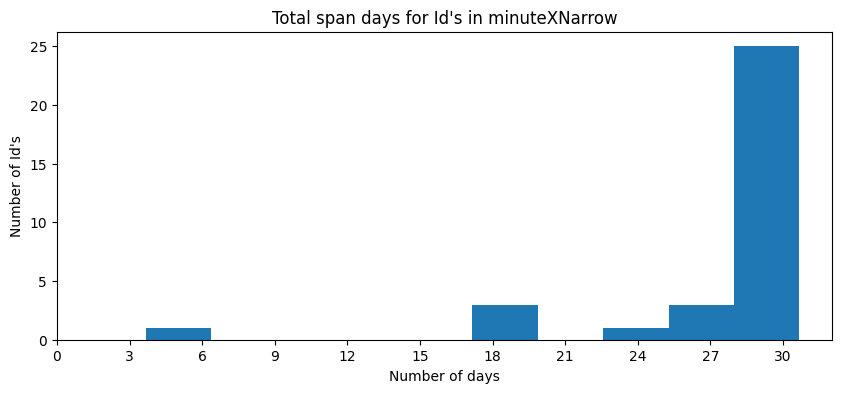

In [18]:
ax = count_calories.set_index('Id').div(60).div(24).plot(figsize = (10,4),\
                                                         use_index = False, \
                                                         title = "Total span days for Id's in minuteXNarrow",\
                                                         kind= 'hist',\
                                                         legend= False,
                                                         xticks = np.arange(0,33,3, dtype = 'int'))
ax.set_xlabel('Number of days')
ax.set_ylabel("Number of Id's")

Abajo podemos ver la cantidad exacta de días representados pars cada id (los datos están transpuestos para ahorrar espacio de visualización). El mínimo es 3.6 días. La diferencia de días hace que los distintos Id's no sean directamente comparables. 
En este contexto, lo más sensato es no tener en cuenta los Id's que tienen poca representación puesto que pueden sesgar nuestros datos negativamente al realizar agregaciones en el futuro.

In [19]:
count_calories.set_index('Id').div(24).div(60).T.sort_values(by = 0, axis='columns', ascending = False)

Id,1927972279,2026352035,2873212765,4558609924,1624580081,4388161847,8053475328,2022484408,2320127002,8877689391,...,3977333714,8792009665,6290855005,6117666160,6775888955,7007744171,3372868164,8253242879,2347167796,4057192912
0,30.666667,30.666667,30.666667,30.666667,30.666667,30.625,30.625,30.625,30.625,30.583333,...,29.0,28.0,27.708333,27.5,25.416667,25.041667,19.666667,17.958333,17.25,3.666667


Convertimos los datos temporales a formato datetime para realizar cálculos sobre las fechas.

In [20]:
# Renombramos los Datasets por comodidad.
calories = all_df['minuteCaloriesNarrow_merged'].copy()
intensities = all_df['minuteIntensitiesNarrow_merged'].copy()
MET = all_df['minuteMETsNarrow_merged'].copy()
steps = all_df['minuteStepsNarrow_merged'].copy()

In [21]:
# We convert ActivityMinute to datetime. Calories already converted in appendix. 
# We also create a Day_and_hour to help group by in the future

# calories['datetime'] = pd.to_datetime( calories.pop('ActivityMinute'), \
#                                           format = '%m/%d/%Y %I:%M:%S %p' )

# Intensidades ---
intensities['datetime'] = pd.to_datetime( intensities.pop('ActivityMinute'), \
                                          format = '%m/%d/%Y %I:%M:%S %p' )
intensities['Day_and_hour'] = intensities['datetime'].dt.strftime('%Y-%m-%d %H')

# MET ----
MET['datetime'] = pd.to_datetime( MET.pop('ActivityMinute'), \
                                          format = '%m/%d/%Y %I:%M:%S %p' )
MET['Day_and_hour'] = MET['datetime'].dt.strftime('%Y-%m-%d %H')


#Steps -----
steps['datetime'] = pd.to_datetime( steps.pop('ActivityMinute'), \
                                    format = '%m/%d/%Y %I:%M:%S %p' )
steps['Day_and_hour'] = steps['datetime'].dt.strftime('%Y-%m-%d %H')


A continuación analizamos el rango explícito de fechas con horas que cubre cada Id.
Notamos lo siguiente: El mínimo siempre es 2016-04-12 00:00:00 y el máximo varía demasiado. Siendo 2016-05-12 15:59:00 es valor más alto.

In [22]:
# Exploremos los rangos minimos y maximos de fechas.
max_min_dates_table = calories.groupby('Id').agg(min_date = ('datetime', 'min'),
                           max_date = ('datetime', 'max'))
max_min_dates_table

,min_date,max_date
Id,,
1503960366,2016-04-12,2016-05-11 20:59:00
1624580081,2016-04-12,2016-05-12 15:59:00
1644430081,2016-04-12,2016-05-11 11:59:00
1844505072,2016-04-12,2016-05-12 10:59:00
1927972279,2016-04-12,2016-05-12 15:59:00
2022484408,2016-04-12,2016-05-12 14:59:00
2026352035,2016-04-12,2016-05-12 15:59:00
2320127002,2016-04-12,2016-05-12 14:59:00
2347167796,2016-04-12,2016-04-29 05:59:00


### Filtro por rango de fechas común
Decidimos solo considerar los Id's que cuentan con el rango completo:
2016-04-12 00:00:00 - 2016-05-12 00:00:00.

De esta manera tenemos uniformidad en los registros de los clientes y podemos estar seguros de hacer comparaciones completas entre los mismos.

In [23]:
from datetime import datetime
limit_date = datetime.strptime('2016-05-11 23:59:01', '%Y-%m-%d %H:%M:%S')

ids_full_month = max_min_dates_table[max_min_dates_table['max_date'] >= limit_date].index

#Just id's with full month
calories = calories.loc[calories['Id'].isin(ids_full_month)]
intensities = intensities.loc[intensities['Id'].isin(ids_full_month)]
MET = MET.loc[MET['Id'].isin(ids_full_month)]
steps = steps.loc[steps['Id'].isin(ids_full_month)]

# Now, delete extra records.
calories = calories.loc[calories['datetime']<limit_date]
intensities = intensities.loc[intensities['datetime']<limit_date]
MET = MET.loc[MET['datetime']<limit_date]
steps = steps.loc[steps['datetime']<limit_date]


### Duplicados
Como podemos observar a continuación no hay valores duplicados por Id y fecha.

In [24]:
print(calories.duplicated(['Id', 'datetime']).sum())
print(intensities.duplicated(['Id', 'datetime']).sum())
print(MET.duplicated(['Id', 'datetime']).sum())
print(steps.duplicated(['Id', 'datetime']).sum())

0
0
0
0


### Consistencia de las fechas
Para verificar que nuestra limpieza es correcta, debemos asegurarnos de que la fecha que estamos cubriendo es la correcta.De acuerdo a lo que hemos hecho nuestro span de fechas debe coincidir con el span desde 2016-04-12 00:00:00 hasta 2016-05-11 23:59:00 minuto a minuto.

In [25]:
rango_completo = pd.Series(pd.date_range('2016-04-12 00:00:00', '2016-05-11 23:59:00' , freq= 'T'))
rango_completo

0       2016-04-12 00:00:00
1       2016-04-12 00:01:00
2       2016-04-12 00:02:00
3       2016-04-12 00:03:00
4       2016-04-12 00:04:00
                ...        
43195   2016-05-11 23:55:00
43196   2016-05-11 23:56:00
43197   2016-05-11 23:57:00
43198   2016-05-11 23:58:00
43199   2016-05-11 23:59:00
Length: 43200, dtype: datetime64[ns]

In [26]:
def ver_rango_completo(group):
    return (group.datetime.reset_index(drop=True)).equals(rango_completo)
# Añade columna booleana que evalua para cada id si el rango de datetime es igual rango_completo.
# Depués con all() devuelve True indicando que todos los Id's tienen el rango completo.
print(calories.groupby('Id').apply(ver_rango_completo).all())
print(intensities.groupby('Id').apply(ver_rango_completo).all())
print(MET.groupby('Id').apply(ver_rango_completo).all())
print(steps.groupby('Id').apply(ver_rango_completo).all())

True
True
True
True


### Sueño

Notamos 
1) No todos los id's de los datos anteriores están representados. En realidad solo hay 15 de los 19. Para los otros 4 no hay datos.
2) Muy pocos id's tienen varios registros. De hecho lo normal es que falten varios registros de sueño.

<AxesSubplot:xlabel='Id'>

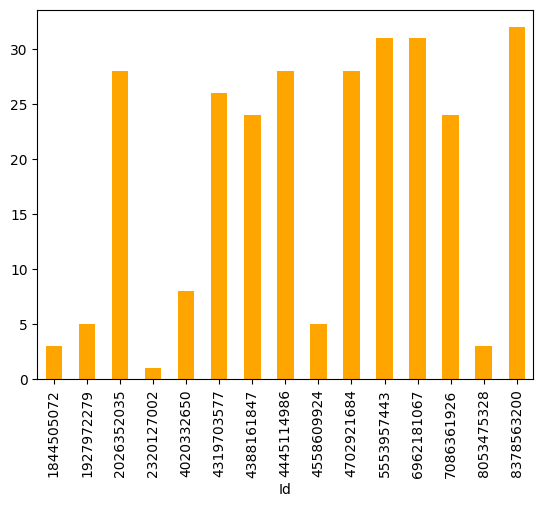

In [27]:
ids = calories.Id.unique()

sleep = all_df['sleepDay_merged'].copy()
sleep = sleep[sleep['Id'].isin(ids)] #Filtramos por Id

# Representan cuánto se durmió entre la noche anterior y el día actual.
sleep['datetime'] = pd.to_datetime(sleep.pop('SleepDay') , format = '%m/%d/%Y %I:%M:%S %p' )

sleep.groupby('Id')['datetime'].agg('count').plot(kind= 'bar', color = 'orange')

In [28]:
sleep.groupby('Id').agg(min_date = ('datetime', 'min'),\
                        max_date = ('datetime', 'max'), \
                        count = ('datetime', 'count')).sort_values(by = 'count', ascending = False)

,min_date,max_date,count
Id,,,
8378563200,2016-04-12,2016-05-12,32
5553957443,2016-04-12,2016-05-12,31
6962181067,2016-04-12,2016-05-12,31
2026352035,2016-04-12,2016-05-12,28
4445114986,2016-04-12,2016-05-12,28
4702921684,2016-04-12,2016-05-12,28
4319703577,2016-04-14,2016-05-12,26
4388161847,2016-04-15,2016-05-11,24
7086361926,2016-04-12,2016-05-12,24


En este punto lo conveniente sería -de acuerdo al certificado porf. de Google- preguntar al dueño del conjunto de datos sobre las posibles razones de la ausencia de datos y su recomendación para tratar la ausencia de información del sueño ¿Conviene descartar esta información?

Otra posibilidad sería cambiar de conjunto de datos. Sin embargo, dado que el meta-objetivo del proyecto es demostrar habilidades de análisis de datos optamos por la siguiente metodología:

1) Interpolar los datos faltantes para los Id's que se encuentran presentes.
2) Para los Id's faltantes haremos un statistical matching que permita encontrar los id's más similares.

#### Interpolación de minutos de sueño y minutos en cama

A continuación interpolamos el tiempo de sueño y el tiempo de cama para los 15 id's presentes en el dataset sleep. Interpolamos de la siguiente manera:
Para cada día faltante creamos un valor aleatorio con distribución $normal$($\mu_{id} $ , $\sigma_{id} $). Donde $\mu_{id} $  representa el promedio del respectivo id y $\sigma_{id} $ indica la desviación estándar de los registros disponibles del respectivo id. En el caso del Id que tiene un solo registro usamos una desviación estándar de 1. De esta manera los valores de sueño tienen una distribución normal. En particular los Id's con registros de sueño menos volatiles tienen valores aleatorios menos volatiles. Los que cuentan con todos los registros se mantienen inalterados.

El código de abajo puede paracer largo y tedioso. Pero en realidad se puso de esta manera para que el proceso paso a paso sea más evidente. Nota: El código puede ser lento en un dataset grande.

In [29]:
test = sleep.copy()
np.random.seed(13)
dates_index = pd.DatetimeIndex(calories.datetime.dt.date.unique())

all_sleep = []
for iden in test['Id'].unique():
    group = test[test['Id'] == iden]
    mu = group['TotalMinutesAsleep'].mean()
    if np.isnan(group['TotalMinutesAsleep'].std()):
        sigma = 1
    else:
        sigma = group['TotalMinutesAsleep'].std()
    try:
        old_index_series = group.set_index('datetime')
        new_series = old_index_series.loc[~old_index_series.index.duplicated()]
        new_series = new_series['TotalMinutesAsleep'].reindex(dates_index)
    except:
        print(iden)
        break
    #Interpolamos los valores faltantes con valores aleatorios de normal(mu,sigma). Estimamos que los usuarios duermen con una distr normal.
    fulled = new_series.map(lambda x: x if not np.isnan(x) else int(mu + sigma* np.random.standard_normal(size = 1))) 
    df = fulled.to_frame().reset_index().rename({'index': 'datetime'},axis = 'columns' )
    df['Id'] = iden
    
    
    # REPETIMOS PERO CON TotalTimeInBed ------------------------------------------------------------
    group2 = test[test['Id'] == iden]
    mu2 = group['TotalTimeInBed'].mean()
    if np.isnan(group['TotalTimeInBed'].std()):
        sigma2 = 1
    else:
        sigma2 = group['TotalTimeInBed'].std()
    try:
        old_index_series2 = group2.set_index('datetime')
        new_series2 = old_index_series2.loc[~old_index_series2.index.duplicated()]
        new_series2 = new_series2['TotalTimeInBed'].reindex(dates_index)
    except:
        print(iden)
        break
    fulled2 = new_series2.map(lambda x: x if not np.isnan(x) else int(mu2 + sigma2* np.random.standard_normal(size = 1)))
    df2 = fulled2.to_frame().reset_index().rename({'index': 'datetime'},axis = 'columns' )
    df2['Id'] = iden
    
    full_df = df.merge(df2, on = ['Id', 'datetime'])
    all_sleep.append(full_df)

In [30]:
new_sleep = pd.concat(all_sleep, ignore_index = True)
new_sleep = new_sleep[['Id','datetime','TotalMinutesAsleep', 'TotalTimeInBed']]
new_sleep

,Id,datetime,TotalMinutesAsleep,TotalTimeInBed
0,1844505072,2016-04-12,604.0,961.0
1,1844505072,2016-04-13,702.0,961.0
2,1844505072,2016-04-14,649.0,961.0
3,1844505072,2016-04-15,644.0,961.0
4,1844505072,2016-04-16,681.0,961.0
...,...,...,...,...
445,8378563200,2016-05-07,459.0,513.0
446,8378563200,2016-05-08,545.0,606.0
447,8378563200,2016-05-09,359.0,399.0
448,8378563200,2016-05-10,342.0,391.0


In [31]:
#sanity check el id = 5553957443 tiene todos los registros. Corra esta linea solo para verificación.
for i in range(len(new_sleep[new_sleep['Id'] == 5553957443])):
    x= sleep[sleep['Id'] == 5553957443].set_index('datetime')['TotalMinutesAsleep']
    y= new_sleep[new_sleep['Id'] == 5553957443].set_index('datetime')['TotalMinutesAsleep']
    print(x[i], y[i], x[i] == int(y[i]))


441 441.0 True
455 455.0 True
357 357.0 True
377 377.0 True
651 651.0 True
350 350.0 True
520 520.0 True
357 357.0 True
658 658.0 True
399 399.0 True
322 322.0 True
631 631.0 True
553 553.0 True
433 433.0 True
412 412.0 True
347 347.0 True
421 421.0 True
450 450.0 True
775 775.0 True
622 622.0 True
409 409.0 True
380 380.0 True
447 447.0 True
419 419.0 True
400 400.0 True
442 442.0 True
568 568.0 True
453 453.0 True
418 418.0 True
463 463.0 True


#### Matching via Nearest Neighbor (Euclidean distance).

Statistical matching se refiere a una serie de técnicas para identificar (o estratificar) en dos grupos de poblaciones las observaciones más similares con el fin de evaluar el efecto de un tratamiento y asi evitar _cofounding_.

Varios métodos han sido propuestos, uno de los más populares ha sido Propensity Score Matching. Sin embargo, recientemente este método ha recibido serias criticas. Ver [Wikipedia](https://en.wikipedia.org/wiki/Matching_(statistics)).

En este caso, usaremos un algoritmo que encuentra el vecino más cercano en distancia euclidea utilizando np.linalg.norm.

In [32]:
ids_faltantes_sleep = list(set(calories.Id.unique())-set(new_sleep.Id.unique()))

calories_presentes = calories[~calories['Id'].isin(ids_faltantes_sleep)] 
calories_faltantes = calories[calories['Id'].isin(ids_faltantes_sleep)]

In [33]:
# This will take some time since its calculating euclidean norm
ids_fal = []
near = []
for id_fal in calories_faltantes.Id.unique():
    norms = list()
    index = list()
    for id_pre in calories_presentes.Id.unique():
        serie_a = calories_presentes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_pre]
        serie_b = calories_faltantes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_fal]
        # Calcula la distancia euclidea.
        norms.append((np.linalg.norm(serie_a-serie_b)))
        index.append(id_pre)
    vals = pd.Series(norms, index = index)
    near.append(vals.idxmin())
    ids_fal.append(id_fal)
    

Vemos que en particular hay un id que está muy cercano a la mayoría: 1927972279

In [34]:
df_nearest = pd.DataFrame({'id_fal':ids_fal, 'near_id': near})
df_nearest

,id_fal,near_id
0,1624580081,1844505072
1,2022484408,1927972279
2,2873212765,1927972279
3,8877689391,1927972279


Encontramos que al considerar la distancia euclidea las series de timepo tienen formas muy diferentes,a pesar de minimizar la distancia punto a punto. 

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

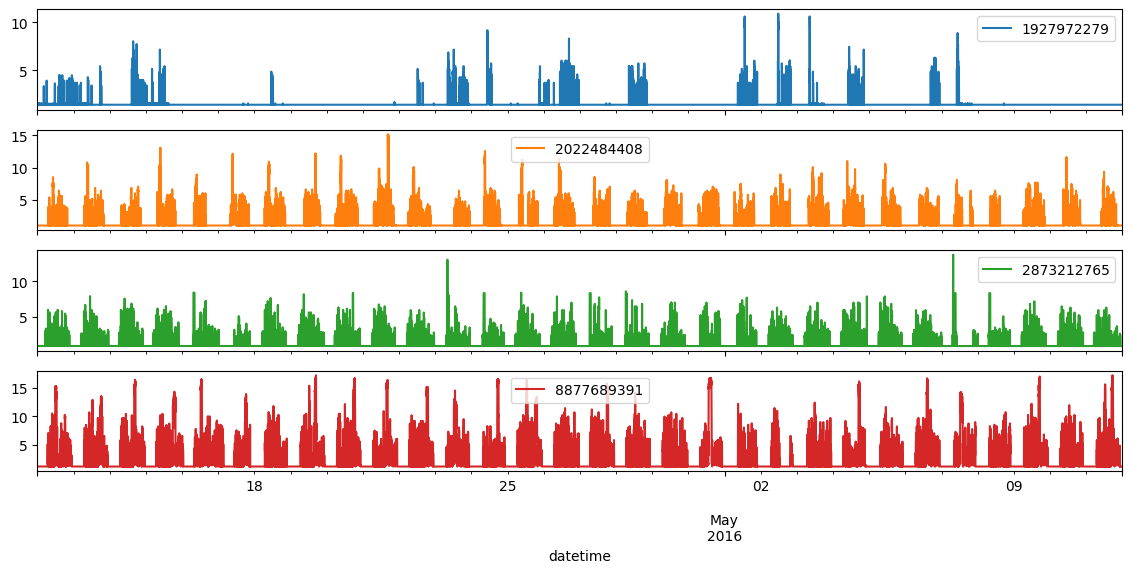

In [35]:
specials = [1927972279, 2022484408, 2873212765, 8877689391]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (14,6))

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

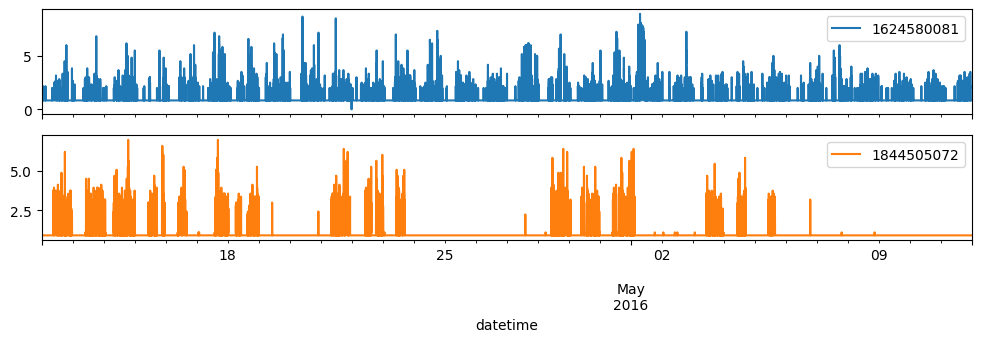

In [36]:
specials = [1624580081 , 1844505072]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (12,3))

#### Matching via Correlation

Otra alternativa sería usar la correlación. Como se expone [aquí](https://tech.gorilla.co/how-can-we-quantify-similarity-between-time-series-ed1d0b633ca0).

In [37]:
ids_fal = []
near = []
for id_fal in calories_faltantes.Id.unique():
    norms = list()
    index = list()
    for id_pre in calories_presentes.Id.unique():
        serie_a = calories_presentes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_pre]
        serie_b = calories_faltantes.set_index(['Id','datetime'])['Calories'].sort_index().loc[id_fal]
        # Calcula la correlación de Pearson.
        norms.append(serie_a.corr(serie_b))
        index.append(id_pre)
    vals = pd.Series(norms, index = index)
    near.append(vals.idxmax())
    ids_fal.append(id_fal)
    

In [38]:
df_nearest_corr = pd.DataFrame({'id_fal':ids_fal, 'near_id': near})
df_nearest_corr

,id_fal,near_id
0,1624580081,6962181067
1,2022484408,6962181067
2,2873212765,6962181067
3,8877689391,7086361926


array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>,
       <AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

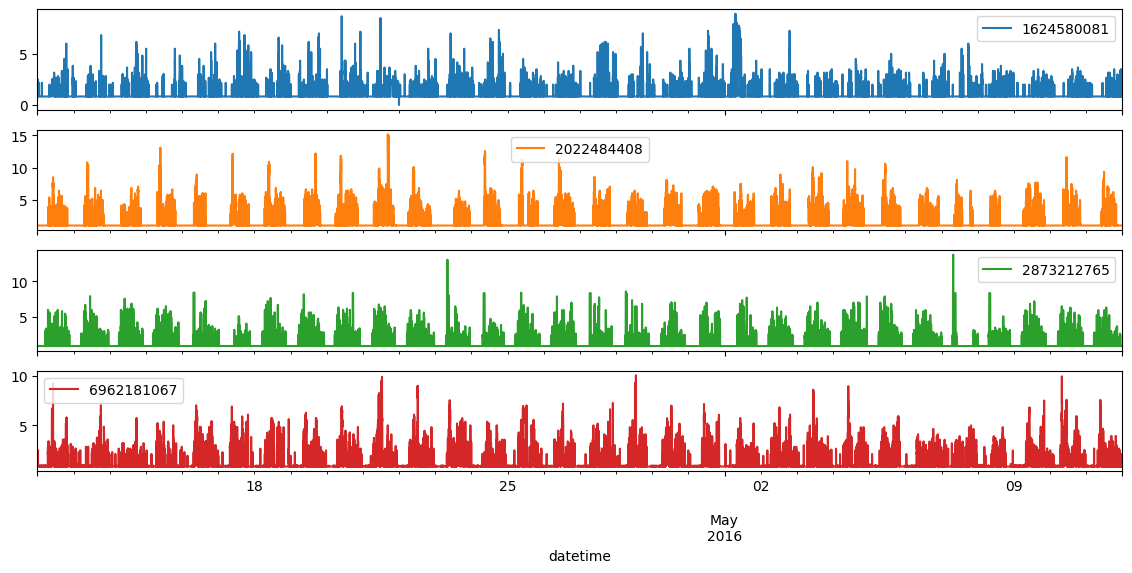

In [39]:
specials = [6962181067, 1624580081, 2022484408, 2873212765]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (14,6))

En este caso preferimos utilizar la correlación ya que las series de tiempo son más similares.

array([<AxesSubplot:xlabel='datetime'>, <AxesSubplot:xlabel='datetime'>],
      dtype=object)

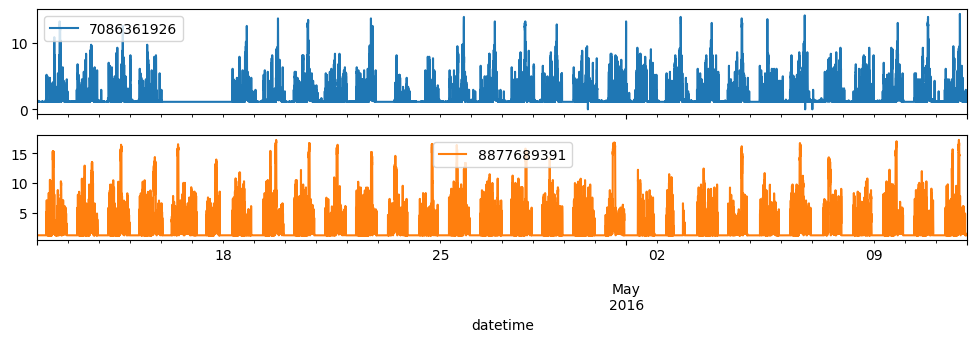

In [40]:
specials = [8877689391 , 7086361926]
calories.set_index('Id').loc[specials].reset_index().pivot(index= 'datetime',\
                                                           columns = 'Id', \
                                                           values = 'Calories')\
.plot(subplots= True, figsize = (12,3))

Ahora añadimos los id's faltantes a los datos de sueño. Siguiendo la siguiente regla:
Los nuevos datos se basan en los del id más cercano de acuerdo al matching que hicimos previamente y agrgamos algo de ruido (añadimos un número aleatorio \* (30 mins) con distribución normal i.e.  una cantidad de minutos en el intervalo -1:30, +1:30 aproximadamente).

In [41]:
df_faltantes_sleep = []
for id_fal in ids_faltantes_sleep:
    id_val = df_nearest_corr.set_index('id_fal').loc[id_fal]
    
    df = pd.DataFrame()
    df['datetime'] = new_sleep[new_sleep.Id == id_val[0]].datetime
    df['Id'] = id_fal
    df['TotalMinutesAsleep'] = new_sleep[new_sleep.Id == id_val[0]].TotalMinutesAsleep
    df['TotalTimeInBed'] = new_sleep[new_sleep.Id == id_val[0]].TotalMinutesAsleep
    
    noise1 = np.array(60*np.random.standard_normal(size = 30), dtype = int)
    noise2 = np.array(60*np.random.standard_normal(size = 30), dtype = int)
    
    df['TotalMinutesAsleep'] = df['TotalMinutesAsleep'] + noise1
    df['TotalTimeInBed'] = df['TotalTimeInBed'] + noise2
    df = df[['Id', 'datetime', 'TotalMinutesAsleep', 'TotalTimeInBed']]
    df_faltantes_sleep.append(df)
    

In [42]:
new_sleep = pd.concat([new_sleep, df_faltantes_sleep[0],\
                      df_faltantes_sleep[1],\
                      df_faltantes_sleep[2],\
                      df_faltantes_sleep[3]], ignore_index = True)
new_sleep

,Id,datetime,TotalMinutesAsleep,TotalTimeInBed
0,1844505072,2016-04-12,604.0,961.0
1,1844505072,2016-04-13,702.0,961.0
2,1844505072,2016-04-14,649.0,961.0
3,1844505072,2016-04-15,644.0,961.0
4,1844505072,2016-04-16,681.0,961.0
...,...,...,...,...
565,8877689391,2016-05-07,494.0,389.0
566,8877689391,2016-05-08,464.0,536.0
567,8877689391,2016-05-09,497.0,410.0
568,8877689391,2016-05-10,451.0,434.0


In [43]:
set(calories.Id.unique()) - set(new_sleep.Id.unique())

set()

### Ritmo cardiaco

En este caso de acuero a las líneas de código de abajo heart solo cuenta con 8 id's de los 19 actuales con los que estamos trabajando. Además los tiempos con registros de ritmo cardiaco se encuntran segundo a segundo en algunos casos. En otros hay saltos de 5 segundos o saltos irregulares. Podemos estandarizar estos datos usando el método _resample_ de pandas.

In [44]:
heart = all_df['heartrate_seconds_merged'].copy()
# Filter to our desidered id's
heart = heart[heart.Id.isin(calories.Id.unique())]
heart['datetime'] = pd.to_datetime(heart.pop('Time'), format =  '%m/%d/%Y %I:%M:%S %p')
heart.head(2)

,Id,Value,datetime
0,2022484408,97,2016-04-12 07:21:00
1,2022484408,102,2016-04-12 07:21:05


In [45]:
print(len(heart.Id.unique())) # Solo hay 8 id's, de manera que faltan 11!!
heart.pivot(columns= 'Id', values = 'Value', index = 'datetime').head(2) #Fijese que el tiempo va de un seg a otro.

8


Id,2022484408,2026352035,4020332650,4388161847,4558609924,5553957443,6962181067,8877689391
datetime,,,,,,,,
2016-04-12 00:00:00,NaN,NaN,63.0,NaN,NaN,61.0,NaN,NaN
2016-04-12 00:00:01,NaN,NaN,64.0,NaN,NaN,NaN,NaN,NaN


Aquí agregamos los datos por minuto, note que empiezan en la fecha y minuto adecuados. Tomamos el promedio por minuto como método de agregación. Los NaN corresponden a valores que no tienen ni un sólo registro en el rango de tiempo comprendido entre la fila actual y la fila siguiente (abierto). Luego restringimos hasta la fecha y hora de interés de nuestro estudio (2016-05-11 23:59:00).

In [46]:
tabla_heart = heart.pivot(columns= 'Id', values = 'Value', index = 'datetime').resample('1T').mean()
tabla_heart = tabla_heart.loc[:'2016-05-11 23:59:01',:]
print(tabla_heart.head(2).iloc[:,:3]) # Fijese que el día y la hora son los correctos
print(tabla_heart.tail(2).iloc[:,:3]) # Fijese que restringimos a la fecha y hora límite de nuestro estudio

Id                   2022484408  2026352035  4020332650
datetime                                               
2016-04-12 00:00:00         NaN         NaN   63.500000
2016-04-12 00:01:00         NaN         NaN   65.913043
Id                   2022484408  2026352035  4020332650
datetime                                               
2016-05-11 23:58:00         NaN         NaN         NaN
2016-05-11 23:59:00         NaN         NaN         NaN


De nuevo, lo ideal sería preguntar a un stakeholder o al dueño de los conjuntos de datos la razón por la que hayan tantos datos faltantes... ¿Por qué es así? ¿Hay un fallo en la importación de datos? ¿Hay otro dataset con datos completos, debemos cambiar de dataset? ¿Acaso las personas normalmente se quitan el dispositivo y por eso hacen falta registros de ritmo cardiaco?

Sin embargo cómo el propósito de este Notebook es demostratr habilidades de análisis de datos vamos a seguir una metodología similar a la del caso del sueño. De manera que ahora disponemos de un problema. La primera parte del problema sería averigüar la manera adecuada de interpolar los datos de rimto cardíaco. Primero que todo, dichos datos están lejos de seguir una distribucuón normal. Más bien el ritmo cardíaco tiene un comportamiento sinusoidal a lo largo del día. Los datos de calorías, intensidades y MET deberían ayudarnos a estimar los valores faltantes.

**Fast check**
Podemos ver que intensidades y MET están intimamente relacionado con ritmo cardiaco. Al menos para el caso del id 4020332650

<AxesSubplot:title={'center':'Steps'}, xlabel='datetime'>

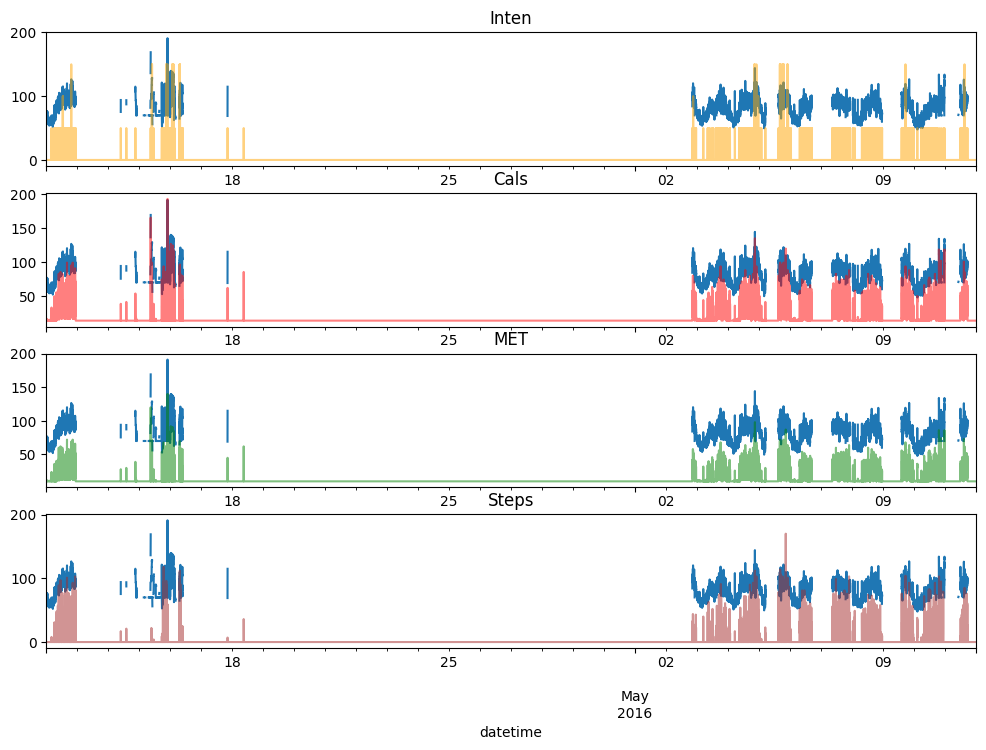

In [47]:
fig,ax = plt.subplots(4,1, figsize= (12,8))
tabla_heart[4020332650].plot(ax = ax[0])
(intensities[intensities.Id == 4020332650].set_index('datetime')['Intensity']*50).plot(color = 'orange', alpha = 0.5, ax = ax[0], title = 'Inten')


tabla_heart[4020332650].plot(ax = ax[1])
(calories[calories.Id == 4020332650].set_index('datetime')['Calories']*10).plot(color = 'red', alpha = 0.5, ax = ax[1], title = 'Cals')

tabla_heart[4020332650].plot(ax = ax[2])
(MET[MET.Id == 4020332650].set_index('datetime')['METs']).plot(color = 'green', alpha = 0.5, ax = ax[2], title='MET')

tabla_heart[4020332650].plot(ax = ax[3])
(steps[steps.Id == 4020332650].set_index('datetime')['Steps']).plot(color = 'brown', alpha = 0.5, ax = ax[3], title = 'Steps')



¿Cuál es el comportamiento típico de MET cuando no hay registros de ritmo cardíaco? 

In [48]:
print(MET[MET.Id == 4020332650].set_index('datetime').METs.iloc[500:600].value_counts()) # Sabemos que en los primeros registros hay actividad
print(MET[MET.Id == 4020332650].set_index('datetime').METs.iloc[5000:5100].value_counts()) # Cuál es el valor típioc de los peridoso debaja actividad?

13    29
12    27
36     9
15     6
30     4
38     4
28     4
32     3
14     2
26     2
42     2
34     2
40     2
11     2
24     1
60     1
Name: METs, dtype: int64
10    98
12     1
11     1
Name: METs, dtype: int64


#### Correlación de ritmo cardíaco con Calories, intentsities, MET and Steps.

A continuación podemos observar un comportamiento idéntico para Calories y METs. Es posible que el cálculo de Mets dependa de calorías de forma directa. En un solo caso calorías tiene una correlación ligeramente mayor +0.01.

In [49]:
def corr_with_cal(series):
    id_actual = series.name
    cals = calories[calories.Id == id_actual].set_index('datetime')['Calories']
    METS = MET[MET.Id == id_actual].set_index('datetime')['METs']
    inten = intensities[intensities.Id == id_actual].set_index('datetime')['Intensity']
    ste = steps[steps.Id == id_actual].set_index('datetime')['Steps']
    
    return pd.Series([cals.corr(series), inten.corr(series), METS.corr(series), ste.corr(series)], \
                     index = ['Cals','Intensities','MET','Steps'])


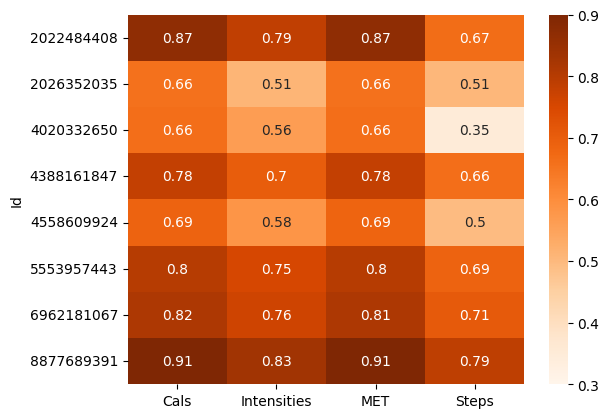

In [50]:
ax = sns.heatmap(tabla_heart.agg(corr_with_cal).T, vmax = .9, vmin= 0.3 , annot = True,\
                linecolor = 'yellow', cmap='Oranges')

Hasta ahora hemos notados dos cosas:

1) Faltan muchos registros de ritmo cardíaco. Una hipótesis es que hay una relación fuerte entre la ausencia de registros de ritmo cardíaco y los registros bajos de Calorías y MET. Puede que esto se deba a que los usuarios remueven su dispositivo y por eso no hay marcación de sus signos vitales. Esto es importante porque **podría ser un indicador del comportamiento de los usuarios**. Dicho lo anterior no vale la pena hacer una interpolación porque establecería un claro sesgo. Reemplazamos los valores faltantes por cero para indicar ausencia de registros (o marcación según nuestra hipótesis). No creemos que se deba a un fallo en la medición del dispositvo, pero es otra posibilidad.
2) De todas las variables las de mayor correlación con ritmo cardíaco fueron MET y Calorías. Usaremos esto para crear datos ficticios de ritmo cardíaco con dos reglas: a) registros bajos de MET los relacionaremos con marcaciones de cero u ausencia de registros en el ritmo cardíaco, que es un patrón razonable.

In [51]:
new_heart = tabla_heart.fillna(0).stack().reset_index().rename(columns = {0:'Values'}).round({'Values':0})
new_heart.head(2)

,datetime,Id,Values
0,2016-04-12,2022484408,0.0
1,2016-04-12,2026352035,0.0


#### Datos ficticios de ritmo cardiaco siguiendo patrón de MET

Tenemos una alta correlación entre MET y ritmo cardíaco. Ahora bien, como regla general usaremos que a 10 MET cero de ritmo cardíaco. Los valores máximos alcanzados son 202 ppm y 146 MET.

**Nota:** Varios estudios parecen tener una escala diferente para MET. Sin embargo el problema de estimar MET a partir del ritmo cardíaco ha sido ampliamente investigado: [ELSEVIER](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6003065/).
La fórmula que utilizan es $$MET = 0.05 × HRnet + 2$$ 

Dado que la relación establecida en ese estudio es lineal, aquí usaremos un enfoque muy similar. 
Nuestras condiciones iniciales exigen que (Ver caso típico abajo): 

$$MET = 12 = LinearFactor \hspace{2 mm} x \hspace{2 mm} HRnet+ C = LF \hspace{2 mm} x \hspace{2 mm} 80 + \hspace{2 mm} C$$

Y las condiciones finales, serían:

$$MET = 146 = LF \hspace{2 mm} x \hspace{2 mm} HRnet+ C  =  LF \hspace{2 mm} x \hspace{2 mm} 202 + C $$

Resolviendo:
 $$ LF \approx 1.09$$
 $$ C \approx -75$$

In [52]:
id_faltantes_heart = list(set(calories.Id.unique())- set(new_heart.Id.unique()))

In [53]:
print('Maximos')
print(new_heart.Values.max(), '----- HRnet Max') # Max heart rate record.
print(MET[~MET.Id.isin(id_faltantes_heart)].METs.max(), '  ----- MET max') # Max MET recorded ids in heart
print('Casos iniciales')
for i in range(525,530):
    print(MET[MET.Id == 4020332650].set_index('datetime').METs.iloc[i], new_heart[new_heart.Id == 4020332650].set_index('datetime').Values.iloc[i])

Maximos
202.0 ----- HRnet Max
146   ----- MET max
Casos iniciales
12 83.0
13 82.0
13 84.0
12 83.0
13 87.0


#### Algortimo de interpolación 
Para completar los id's faltantes usaremos el siguiente algoritmo:
Si MET < 12 entonces HRnet = 0.
De lo contrario usamos la formula de arriba:
$$HR = \dfrac{MET + 75}{1.09}$$

In [54]:
series_fal_heart = []
for iden in id_faltantes_heart:
    Mets = MET[MET.Id == iden].set_index('datetime').METs
    # We meet our condition with np.where faster than an apply. A group by option will be faster but i cant come across a solution rn.
    ser = pd.Series(np.where( Mets >= 12, (Mets+75)/(1.09), 0 ), index= rango_completo)
    ser.name = iden
    series_fal_heart.append(ser)

In [55]:
df_fal_heart_to_add = pd.concat(series_fal_heart, axis = 1).round(0).stack().reset_index().rename(columns = {'level_0': 'datetime',\
                                                                                      'level_1': 'Id',\
                                                                                       0:'Values'})
df_fal_heart_to_add


,datetime,Id,Values
0,2016-04-12 00:00:00,8053475328,0.0
1,2016-04-12 00:00:00,8378563200,0.0
2,2016-04-12 00:00:00,7086361926,80.0
3,2016-04-12 00:00:00,4445114986,0.0
4,2016-04-12 00:00:00,1844505072,0.0
...,...,...,...
475195,2016-05-11 23:59:00,4702921684,80.0
475196,2016-05-11 23:59:00,1927972279,0.0
475197,2016-05-11 23:59:00,4319703577,0.0
475198,2016-05-11 23:59:00,2320127002,0.0


Ahora bien, no todos los registros con un MET de 10 u 11 tienen valores de ritmo cardíaco de 0. 

In [56]:
condition = MET[MET.Id.isin(new_heart.Id.unique())].set_index(['Id','datetime'])['METs'] < 12

De hecho el 46.8 % de ellos tienen un valor diferente de cero. Lo cual es sorprendente dadas las gráficas de arriba.

In [57]:
test = new_heart.set_index(['Id','datetime']).sort_index()['Values'].loc[condition] 
round(((test>0).sum() / len(test))*100,1) # De hecho un porcentaje alto tienen ritmo cardíaco

46.8

In [58]:
print(test[test>0].mean()) #Valor medio de los registros diferentes de cero
print(test[test>0].std()) # (igual que arriba pero std)

63.978160560790236
7.851058171808423


Los valores parecen tener una distribución ligeramente sesgada hacia la derecha.

(30.0, 100.0)

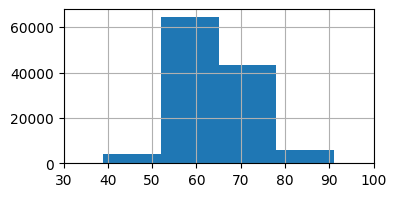

In [59]:
ax = test[test>0].hist(bins = 10, figsize = (4,2))
ax.set_xlim([30,100])

Procedemos a crear un arreglo que siga la distribución anterior. Para ello usamos np.random choice.  Y la asignamos a los datos que tienen un ritmo cardíaco de cero. Esto **compenzará el efecto de la condición MET<12 implica HR = 0** que usamos al definir nuestra función. En particular, cambiamos el 46.8 % de dichos valores.

In [60]:
len(df_fal_heart_to_add[df_fal_heart_to_add.Values == 0].sample(frac = 0.468)) # siempre produce 171440

171440

In [61]:
arreglo = np.random.choice(test[test>0], size =171440)
arreglo

array([63., 57., 64., ..., 69., 74., 56.])

In [62]:
len(df_fal_heart_to_add[df_fal_heart_to_add.Values == 0])

366325

In [63]:
idx = df_fal_heart_to_add[df_fal_heart_to_add.Values == 0].sample(frac=0.468).index
df_fal_heart_to_add.loc[idx,'Values'] = arreglo

In [64]:
len(df_fal_heart_to_add[df_fal_heart_to_add.Values == 0]) # Efectivamente los valores fueron modificados.

194885

En conclusión, 46.8% de los valores fueron modificados siguiendo la distribución de los datos cuyo MET era de 11 o menor para los id's de los que sí teníamos registros. De manera que los datos fictiocios ahora son más similares a los que teníamos en un principio.

In [65]:
df_fal_heart_to_add.loc[idx][:5]

,datetime,Id,Values
429470,2016-05-09 02:42:00,4319703577,63.0
53984,2016-04-15 09:47:00,1927972279,57.0
232785,2016-04-26 16:42:00,4445114986,64.0
101970,2016-04-18 10:30:00,8053475328,66.0
286330,2016-04-30 01:50:00,8053475328,68.0


In [66]:
new_heart = pd.concat([new_heart, df_fal_heart_to_add])

In [67]:
new_heart.tail(2)

,datetime,Id,Values
475198,2016-05-11 23:59:00,2320127002,0.0
475199,2016-05-11 23:59:00,2873212765,70.0


In [68]:
set(calories.Id.unique()) - set(new_heart.Id.unique())

set()

### Peso

In [69]:
pesos = all_df['weightLogInfo_merged'].copy()

In [70]:
pesos.head(3)

,Id,Date,WeightKg,WeightPounds,Fat,BMI,IsManualReport,LogId
0,1503960366,5/2/2016 11:59:59 PM,52.599998,115.963147,22.0,22.650000,True,1462233599000
1,1503960366,5/3/2016 11:59:59 PM,52.599998,115.963147,NaN,22.650000,True,1462319999000
2,1927972279,4/13/2016 1:08:52 AM,133.500000,294.317120,NaN,47.540001,False,1460509732000


Dado que **solo hay registros realmente de 2 id's** para el período de tiempo que nos interesa decidimos que la información está tan incompleta que preferimos descartarla. Además la mayoría de los registros fueron ingresados manualmente, lo que puede llevar a sesgos o errores. Aparte no hay una forma sensata de estimar el peso de una persona basándonos en las características que tenemos hasta ahora.

In [71]:
print('Cantidad de Id\'s presentes: ',len(pesos.Id.unique()), '\n') 

print('Conteo por cada Id \n',pesos.groupby(['Id'])['WeightKg'].count(), '\n')

print('Cantidad de registros que son reporte manual (de 67):' ,pesos['IsManualReport'].sum(), '\n')

Cantidad de Id's presentes:  8 

Conteo por cada Id 
 Id
1503960366     2
1927972279     1
2873212765     2
4319703577     2
4558609924     5
5577150313     1
6962181067    30
8877689391    24
Name: WeightKg, dtype: int64 

Cantidad de registros que son reporte manual (de 67): 41 



### Transparencia de los datos
**Nota**: Un punto importante aquí es que los datos fueron suministrados por consentimiento propio de los usuarios respondiendo a una encuesta de Amazon Mechanical Turk. No tenemos claridad sobre la veracidad de los datos de peso. Aparentemente fueron suministrados de manera subjetiva y no por calculos hechos por el dispotivo FitBit. De manera que esta variable no es confiable.

### Dataset final y resumen

In [72]:
new_heart = new_heart.rename(columns = {'Values': 'HeartRate'})
df = (((calories.merge(intensities, on = ['Id', 'datetime', 'Day_and_hour']))\
         .merge(MET, on = ['Id', 'datetime', 'Day_and_hour'] ))\
         .merge(steps, on = ['Id', 'datetime', 'Day_and_hour']))\
         .merge(new_heart, on = ['Id','datetime'])
df['DayOfWeek'] = df['datetime'].dt.day_name()
df['Hour'] = df['datetime'].dt.hour
df = df[['Id','datetime','Day_and_hour','DayOfWeek', 'Hour','Calories', 'Intensity', 'METs', 'Steps','HeartRate']]

In [73]:
df.head()

,Id,datetime,Day_and_hour,DayOfWeek,Hour,Calories,Intensity,METs,Steps,HeartRate
0,1624580081,2016-04-12 00:00:00,2016-04-12 00,Tuesday,0,0.831,0,10,0,0.0
1,1624580081,2016-04-12 00:01:00,2016-04-12 00,Tuesday,0,0.831,0,10,0,67.0
2,1624580081,2016-04-12 00:02:00,2016-04-12 00,Tuesday,0,0.831,0,10,0,0.0
3,1624580081,2016-04-12 00:03:00,2016-04-12 00,Tuesday,0,0.831,0,10,0,66.0
4,1624580081,2016-04-12 00:04:00,2016-04-12 00,Tuesday,0,0.831,0,10,0,66.0


**Resumen**: Hicimos limpieza de las datos de la siguiente manera:
1. Restringimos el rango de fechas desde 2016-04-12 hasta 2016-05-11 minuto a minuto. Esto para tener información de tiempo comparable para los Id's. Aquí se usaron todos los datos de Calorías, Intensidades, METs y Steps.
2. Interpolamos usando statistical matching registros faltantes de sueño y añadimos ruido normal para completar registros inexistentes de algunos Id's a fin de evitar sesgo. Estos datos son diarios para el mismo período anterior.
3. Interpolamos datos faltantes de ritmo cardíaco usando fórmula que relaciona METs. Además añadimos registros inexistentes con la misma fórmula + resampleo aleatorio de los registros existentes para tener datos que respeten la distribución original de los Id's presentes.
4. No consideramos los datos de Peso al ser la mayoría de registro del usuario. Sujetos a sesgo o malas mediciones. Además datos muy incompletos para todos los Id's. Imposible de interpolar.

## 2 Data Analysis 


### **¿Qué caracteriza a los usuarios de un smartwatch _FitBit_? ¿Vale la pena comprarlo?**
Intentaremos dar una narrativa (storytelling) a esta pregunta con el fin de presentarsela a los stakeholders. Para ello, pretendemos responder las siguientes preguntas:

* A. ¿Qué tanto hacen ejercicio? ¿Cuál es su duración típica ejercitandose? ¿Prefieren la tarde o la mañana para ejercitarse?
* B. ¿Cómo se relaciona su consumo de calorías con el sueño? ¿Duermen bien?
* C. ¿Realmente los usuarios de FitBit usan el dispositivo, qué tanto? ¿En qué tiempo suelen usarlo más y cuándo menos? -- (¿Usar una exponencial para estimar el tiempo entre usos?)




### A) Preferencias ejercicio

Comenzaremos investigando las horas de mayor consumo calórico.

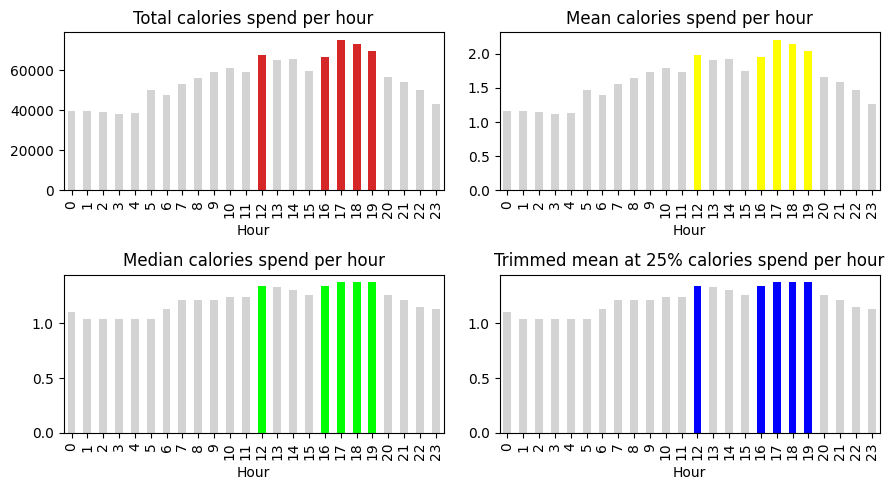

In [74]:
def trim_mean_group(group):
    from scipy.stats import trim_mean
    return trim_mean(group, 0.25)

fig, axes = plt.subplots(2,2,figsize = (9,5))

suma = df.groupby(['Hour'])['Calories'].sum()
my_colors = np.array(['lightgrey']*24)
my_colors[list(suma.nlargest(5).index)] = 'tab:red'
suma.plot.bar( title = 'Total calories spend per hour', ax = axes[0,0], color = my_colors)

prom = df.groupby(['Hour'])['Calories'].mean()
my_colors = np.array(['lightgrey']*24)
my_colors[list(prom.nlargest(5).index)] = 'yellow'
prom.plot.bar( title = 'Mean calories spend per hour', ax = axes[0,1], color = my_colors)


mediana = df.groupby(['Hour'])['Calories'].median()
my_colors = np.array(['lightgrey']*24)
my_colors[list(mediana.nlargest(5).index)] = 'lime'
mediana.plot.bar(title = 'Median calories spend per hour', ax =  axes[1,0], color = my_colors)

trimmed_mean = df.groupby(['Hour'])['Calories'].agg(trim_mean_group)
my_colors = np.array(['lightgrey']*24)
my_colors[list(trimmed_mean.nlargest(5).index)] = 'blue'
mediana.plot.bar(title = 'Trimmed mean at 25% calories spend per hour', ax =  axes[1,1], color = my_colors)

fig.tight_layout()

Es inmediatamente claro que las **5 horas con mayor consumo calórico** son las **12:00** y luego **desde 16:00 hasta las 19:00**. Lo más probable es que estás sean las horas de mayor actividad.

Sin embargo, el efecto se ve reducido considerablemente cuando se utiliza la mediana o la media truncada al 0.25 (trimmed). Indicando que los **valores medios son muy similares**. La diferencia puede deberse a que existen registros relativamente altos (o particulamente bajos). Es probable que existan Id's con consumos calóricos mucho mayores y otros con otro patrón de consumo.

Tenemos dos nuevas preguntas:
* ¿Este patrón de horas se ve confirmado por Steps, Intensities y ritmo cardíaco?
* ¿Para todos los id's estas son las horas de mayor consumo calórico?

<AxesSubplot:title={'center':'Mean Intensity per hour'}, xlabel='Hour'>

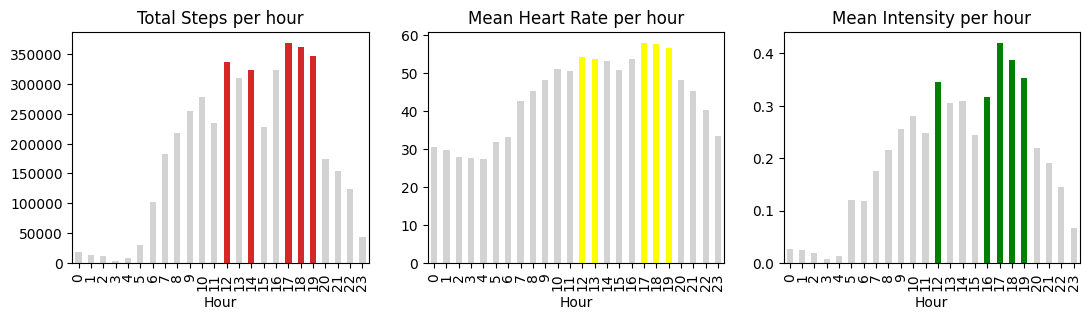

In [75]:
fig, axes = plt.subplots(1,3, figsize = (13,3))

ste= df.groupby(['Hour'])['Steps'].sum()
my_colors = np.array(['lightgrey']*24)
my_colors[list(ste.nlargest(5).index)] = 'tab:red'
ste.plot.bar(ax = axes[0], title = 'Total Steps per hour', color = my_colors)

HR = df.groupby(['Hour'])['HeartRate'].mean()
my_colors = np.array(['lightgrey']*24)
my_colors[list(HR.nlargest(5).index)] = 'yellow'
HR.plot.bar(ax = axes[1], title = 'Mean Heart Rate per hour', color = my_colors)

inten = df.groupby(['Hour'])['Intensity'].mean()
my_colors = np.array(['lightgrey']*24)
my_colors[list(inten.nlargest(5).index)] = 'green'
inten.plot.bar(ax = axes[2], title = 'Mean Intensity per hour', color = my_colors)

El patrón no se sigue exactamente igual entre las variables con respecto al consumo de calorías. Sin embargo, sí se confirma que los Id's están más activos en las horas de la tarde. Curiosamente a las 15:00 siempre hay un bajón. Las horas más activas siempre son 12:00 y desde las 17:00 hasta las 19:00. 

In [76]:
top_5_active_hours_perid = (df.groupby(['Id','Hour'])['Calories'].mean().groupby(level=0)).nlargest(5).droplevel(0)
top_5_active_hours_perid

Id          Hour
1624580081  19      1.263120
            18      1.211783
            9       1.188330
            10      1.179928
            13      1.161461
                      ...   
8877689391  18      4.892541
            12      4.591900
            17      4.319263
            16      3.757214
            13      3.047892
Name: Calories, Length: 95, dtype: float64

<AxesSubplot:title={'center':"Frequency of most active Hours over all Id's"}>

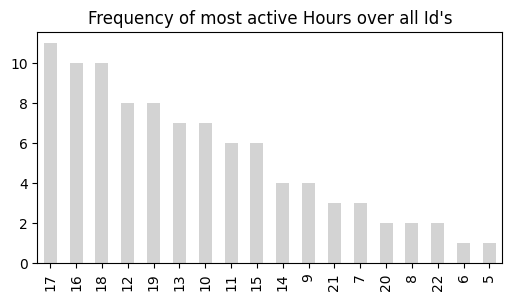

In [77]:
top_5_active_hours_perid.reset_index()['Hour'].value_counts().plot.bar(color = 'lightgrey', \
                                                                       title = "Frequency of most active Hours over all Id's", figsize = (6,3))

Podemos ver que la mayoría de usuarios son más activos en la tarde. Es interesante ver que algunos tienen mayor actividad a las 5:00, "madrugadores".

In [78]:
top_5 = top_5_active_hours_perid.reset_index()
top_5[top_5['Hour']<= 11].groupby('Id')['Hour'].count()

Id
1624580081    2
1844505072    2
1927972279    2
2022484408    3
2320127002    1
2873212765    4
4319703577    2
4388161847    1
5553957443    1
6962181067    3
8378563200    3
Name: Hour, dtype: int64

Algunos Id's definitivamente son más activos en la mañana. Otros son mixtos al tener algo de actividad antes de las 11:00 y el resto en la tarde.

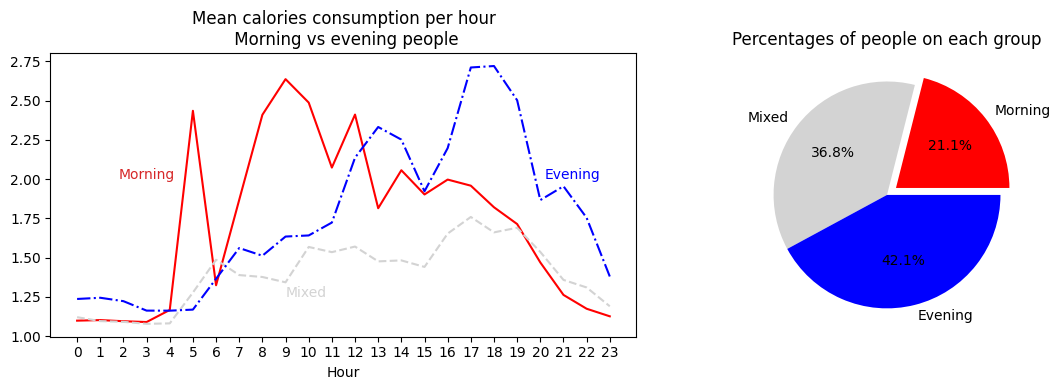

In [79]:
before_11_atleast = top_5[top_5['Hour']<= 11].groupby('Id')['Hour'].count()

full_morning_people = before_11_atleast[before_11_atleast >=3].index
mixed = before_11_atleast[before_11_atleast < 3].index
full_afternoon_people = list(set(top_5.Id.unique()) - set(full_morning_people) - set(mixed))

fig, axes = plt.subplots(1,2, figsize = (12,4))

df[df.Id.isin(full_morning_people)].groupby(['Hour'])['Calories'].mean().plot(ax = axes[0], linestyle="solid",\
                                                                              color = 'red')
df[df.Id.isin(mixed)].groupby(['Hour'])['Calories'].mean().plot(ax = axes[0],linestyle="--",\
                                                                color = 'lightgrey')
df[df.Id.isin(full_afternoon_people)].groupby(['Hour'])['Calories'].mean().plot(ax = axes[0],linestyle="dashdot",\
                                                                color = 'blue')
axes[0].set_title('Mean calories consumption per hour\n Morning vs evening people')
axes[0].set_xticks(range(24))
axes[0].text(1.8,2,'Morning', color = 'tab:red')
axes[0].text(20.2,2, 'Evening', color = 'blue')
axes[0].text(9,1.25, 'Mixed', color = 'lightgrey')

labels = ['Morning', 'Mixed', 'Evening']
sizes = [len(full_morning_people), len(mixed), len(full_afternoon_people)]
explode = (0.1,0,0)
colors = ['red', 'lightgrey', 'blue']
axes[1].pie(sizes, labels= labels, autopct='%1.1f%%', explode = explode, colors = colors)
axes[1].set_title('Percentages of people on each group')

fig.tight_layout()
plt.savefig('img1.png')

Podemos ver que la mayoría de Id's tienen un mayor consumo calórico en las tardes. Claramente los grupos de la mañana y de la tarde tienen en promedio mayor consumo calórico que aquellos cuyo consumo es mixto. Parece que las personas de la mañana son ligeramente más activas a lo largo del día. A continuación exploramos el comportamiento por días de la semana. Cabe aclarar que debido al rango de fechas, los días Martes y Miércoles están más representados, por lo que los valores totales (sumas) no son útiles para comparaciones. Por ello optamos por la media.

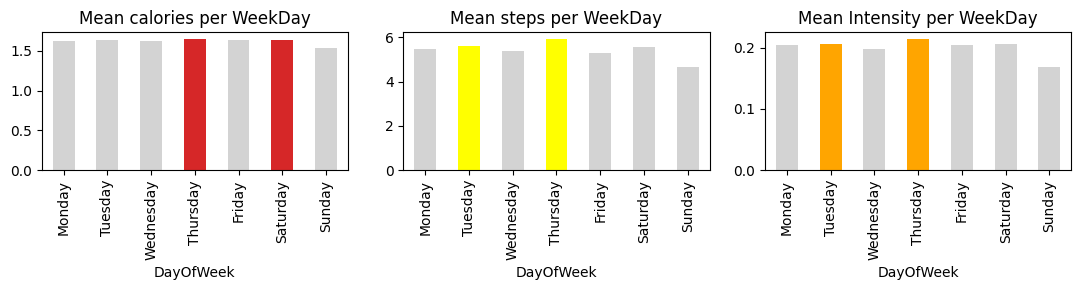

In [80]:
fig, axes = plt.subplots(1,3, figsize = (11,3))

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

media_cal = df.groupby(['DayOfWeek'])['Calories'].mean().reindex(days_order, axis = 0)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[media_cal.nlargest(2).index] = 'tab:red'
media_cal.plot.bar( title = 'Mean calories per WeekDay',ax = axes[0], color = my_colors)

media_ste = df.groupby(['DayOfWeek'])['Steps'].mean().reindex(days_order, axis = 0)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[media_ste.nlargest(2).index] = 'yellow'
media_ste.plot.bar( title = 'Mean steps per WeekDay',ax = axes[1], color = my_colors)


media_inten = df.groupby(['DayOfWeek'])['Intensity'].mean().reindex(days_order, axis = 0)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[media_inten.nlargest(2).index] = 'orange'
media_inten.plot.bar( title = 'Mean Intensity per WeekDay',ax = axes[2], color = my_colors)
fig.tight_layout()


In [81]:
print('Standard deviation per dow')
df.groupby(['DayOfWeek'])[['Calories', 'Steps', 'Intensity']].std().reindex(days_order)

Standard deviation per dow


,Calories,Steps,Intensity
DayOfWeek,,,
Monday,1.474461,18.366855,0.526019
Tuesday,1.477021,18.918032,0.530748
Wednesday,1.489269,18.711355,0.513628
Thursday,1.480759,19.373261,0.535834
Friday,1.454017,17.906234,0.515864
Saturday,1.489695,18.692874,0.519396
Sunday,1.320021,17.653895,0.478573


No vemos diferencias significativas en cuanto a las preferencias de actividad durante algún día de la semana. Sí vemos que los domingos son consistentemente los días menos activos. ¿Para los usarios activos en la mañana es cierto esto?

Por otra parte vemos que (tabla arriba) las desviaciones estándar son muy similares en todos los días. Sugiriendo aún mayor similitud en los datos. Note que las desviaciones estándar de los pasos son de aprox 18 en todos los casos, mientras que la media es de 6. Esto indica que hay muhcos valores con 0 pasos y que existen otros valores mayores extremos.

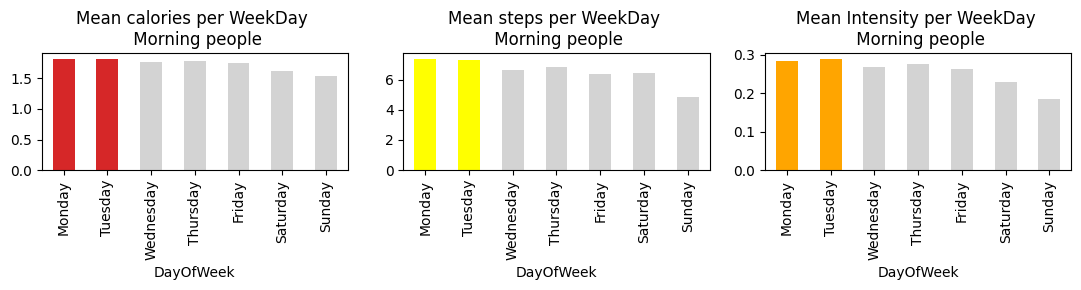

In [82]:
fig, axes = plt.subplots(1,3, figsize = (11,3))

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

media_cal = df[df.Id.isin(full_morning_people)].groupby(['DayOfWeek'])['Calories'].mean().reindex(days_order, axis = 0)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[media_cal.nlargest(2).index] = 'tab:red'
media_cal.plot.bar( title = 'Mean calories per WeekDay \n Morning people',ax = axes[0], color = my_colors)

media_ste = df[df.Id.isin(full_morning_people)].groupby(['DayOfWeek'])['Steps'].mean().reindex(days_order, axis = 0)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[media_ste.nlargest(2).index] = 'yellow'
media_ste.plot.bar( title = 'Mean steps per WeekDay \n Morning people',ax = axes[1], color = my_colors)


media_inten = df[df.Id.isin(full_morning_people)].groupby(['DayOfWeek'])['Intensity'].mean().reindex(days_order, axis = 0)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[media_inten.nlargest(2).index] = 'orange'
media_inten.plot.bar( title = 'Mean Intensity per WeekDay \n Morning people',ax = axes[2], color = my_colors)
fig.tight_layout()


Para las personas de mayor actividad en la mañana sí encontramos un patrón de preferencia hacia los días lunes y martes. Sin embargo, es evidente que el efecto no es considerable. Dado que tenemos pocos datos es probable que el efecto sea una mera coincidencia.

**A continuación veremos qué tan seguido o qué tanto hacen ejercicio estas personas basándonos en las intensidades**

Para ello vamos a tener en cuenta las intensidades. Una intensidad de 2 o superior por un tiempo prolongado indica que hubo actividad física. Vamos a calcular las cadenas consecutivas en una intensidad de 2 o superior. Primero haremos una exploración mjuy superficial de esta posibilidad.

In [83]:
def calculate_streak_intensity(group):
    """
    Calcula la longitud de cadenas cuyo valor de intensidad sea mayor a 2 de forma consecutiva.
    Explicación:
    Apenas haya un cambio la condicion != se hará true hasta el siguiente cambio. 
    Al añadir cumsum() todos los valores 'true' compartiran la misma suma acumulada hasta entonces. Un nuevo valor de cumsum no aparecerá
    sino que haya un nuevo cambio a False. Es decir hasta que se acabe la cadena.
    Tenemos una cadena booleana agrupada por los grupos de cadena. Sobre ella aplicamos un cumsum() final que solo sumará las cadenas que inician
    con un cambio positivo y terminan con un cambio negativo (de True a False, i.e. de intensidad 2 o mayor a intensidad 1 o menor).
    """
    sign = group['Intensity'] >= 2
    streaks = sign.groupby((sign!=sign.shift()).cumsum()).cumsum()
    group['streaks'] = streaks
    return group



In [84]:
df = df.groupby(['Id']).apply(calculate_streak_intensity)

Las siguientes gráficas muestran frecuencias de longitudes de cadena superiores a 30 min.

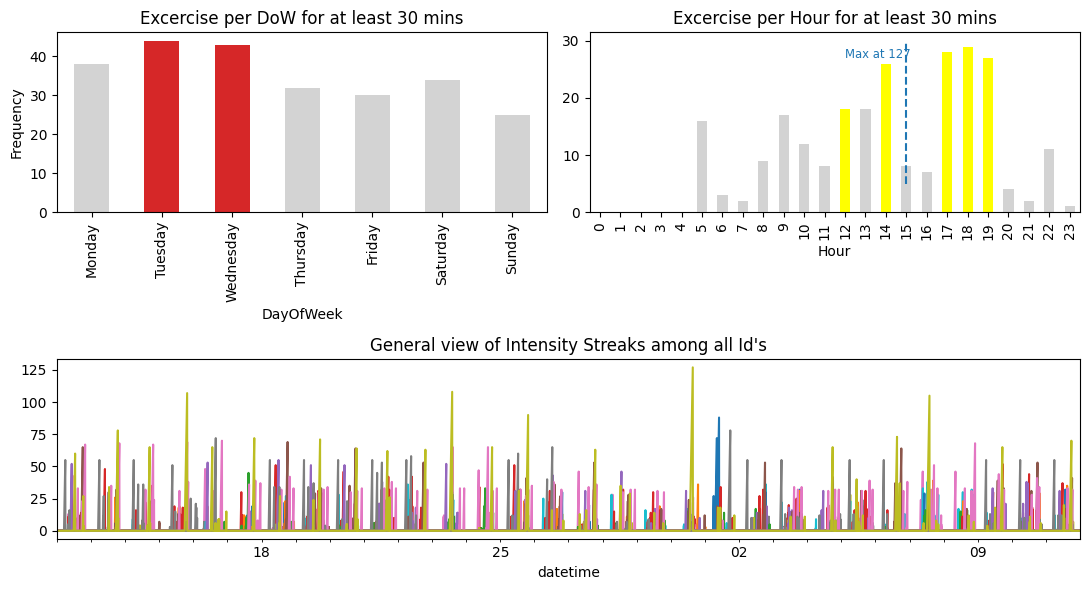

In [85]:
fig = plt.figure(figsize = (11,6))

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])

excercise_per_dow = (df.groupby(['Id','Day_and_hour','DayOfWeek'])['streaks'].max() > 30).groupby('DayOfWeek').sum().reindex(days_order)
my_colors = pd.Series(['lightgrey']*7, index = days_order)
my_colors.loc[excercise_per_dow.nlargest(2).index] = 'tab:red'
excercise_per_dow.plot.bar(title = 'Excercise per DoW for at least 30 mins', color = my_colors ,ax = ax1)
ax1.set_ylabel("Frequency")

excercise_per_hour = (df.groupby(['Id','Day_and_hour','Hour'])['streaks'].max() > 30).groupby('Hour').sum()
my_colors = pd.Series(['lightgrey']*24)
my_colors.loc[excercise_per_hour.nlargest(5).index] = 'yellow'
excercise_per_hour.plot.bar(title = 'Excercise per Hour for at least 30 mins', color = my_colors ,ax = ax2)
ax2.vlines(x = 15, ymin = 5, ymax = 30,linestyles = 'dashed')
ax2.text(12,27, 'Max at 127' ,fontsize = 'small', color = 'C0')

# This is a pretty dense graph
df.pivot(index = 'datetime', columns = 'Id', values = 'streaks').plot(title = "General view of Intensity Streaks among all Id's",\
                                                                     legend = False, ax = ax3)
ax3.set_xticks([])
fig.tight_layout()
plt.show()

Las gráficas de arriba calculan los días y las horas más frecuentes en los que las personas terminan sus cadenas de ejercicio de al menos 30 minutos. 

Podemos ver que **la mayoría del ejercicio físico ocurre los primeros días de la semana: Lunes, Martes, Miércoles**. Como era de esperarse los domingos son los días en los que las personas menos se ejercitan. ¿Tendrá que ver con los excesos del fin de semana? ¿o aumentará el trabajo en esos días? No tenemos cómo comprobarlo. Cómo pregunta para el futuro, ¿serán también los días con menos sueño?

Por otro lado, la **mayoría de horas de ejercicio se concentra en horas de la tarde**, siendo las **12:00**, y desde las **17:00 hasta las 19:00 hrs** las horas de mayor actividad. Esto coincide con nuestros hallazgos de las horas más activas por consumo de calorías. ¿Será lo mismo para los id's más activos en la mañana? Probablemente no. Sorprendentemente las 15:00 suponen un período poco activo, sin embargo la cadena más larga termina aquí. Sugiriendo que alguien se ejercitó aproximadamente dos horas (127 mins) y terminó su ejercicio a las 15:00. Este sujeto es el mismo en amarillo en la compleja serie de tiempo de la parte baja de la gráfica. Vemos que constantemente se ejercita más que los demás, una bestia, ánimo!

A continuación respondemos 3 preguntas.
* A) ¿Cómo son las cadenas de ejercicio de las personas de la mañana?
* B) ¿Podemos agrupar personas por grupos de atleticos, normales y poco atleticos? ¿Qué porcentajes tenemos?
* C) ¿Podemos determinar si estas personas prefieren hacer ejercicio de larga duración o de corta duración, a un umbral de 45 mins?

Text(0.5, 1.0, 'Percentages of people on each group')

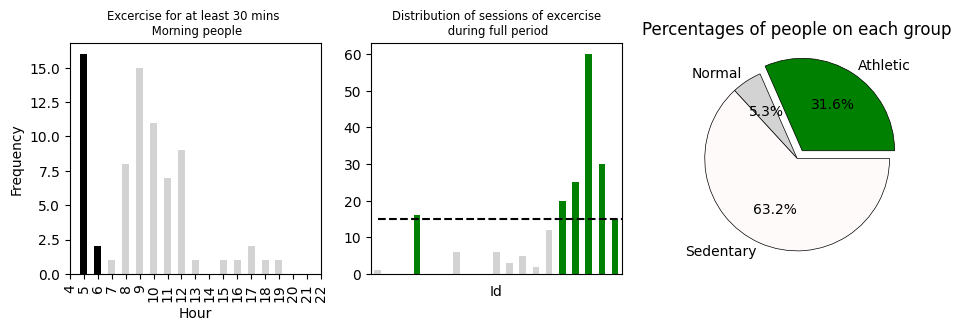

In [90]:
fig, axes = plt.subplots(1,3, figsize = (11,3))

ex_morning = (df[df.Id.isin(full_morning_people)].groupby(['Id','Day_and_hour','Hour'])['streaks'].max() > 30).groupby('Hour').sum()
ex_morning.plot.bar(ylabel = 'Frequency',\
                    color = ['black']*7 + ['lightgrey']*17, ax = axes[0])
axes[0].set_xlim([4,22])
axes[0].set_title('Excercise for at least 30 mins \n Morning people', fontsize = 'small')


# To avoid double counting succesive periods of large streaks we limit our results to atleast 30 but also less than 59
# In this way if somebody spent 100 minutes, thats one session, and we are not counting two or three sessions that corresponds to
# the number of Hrs in the span that can be 'covered' by a 100 mins period. gotcha?

sessions_fullPeriod_perId = ((df.groupby(['Id','Day_and_hour','Hour'])['streaks'].max() > 30) \
 & (df.groupby(['Id','Day_and_hour','Hour'])['streaks'].max() < 59)).groupby(['Id']).sum()
my_colors = pd.Series(['lightgrey']*19, index = sessions_fullPeriod_perId.index)
my_colors.loc[sessions_fullPeriod_perId >=15] = 'green'
sessions_fullPeriod_perId.plot.bar(ax = axes[1], color = my_colors)
axes[1].hlines(15, xmin=0,xmax=19 ,linestyles= 'dashed', color = 'black')
axes[1].set_xticks([])
axes[1].set_title('Distribution of sessions of excercise\n during full period', fontsize = 'small')


athl = sessions_fullPeriod_perId.loc[sessions_fullPeriod_perId >=15]
normal_ex = sessions_fullPeriod_perId.loc[(sessions_fullPeriod_perId < 15) & (sessions_fullPeriod_perId >=8)] 
sedentary = sessions_fullPeriod_perId.loc[sessions_fullPeriod_perId < 7]

labels = ['Athletic', 'Normal', 'Sedentary']
sizes = [len(athl), len(normal_ex), len(sedentary)]
explode = (0.1,0,0)
colors = ['green', 'lightgrey', 'snow']
axes[2].pie(sizes, labels= labels, autopct='%1.1f%%', explode = explode, colors = colors, wedgeprops = {'edgecolor':'black' ,'linewidth': 0.5})
axes[2].set_title('Percentages of people on each group')

Note que A) evidentemente las **personas de temprano en la mañana** cumplen **la mayoría de sus sesiones de ejercicio intenso a las 5:00 o a las 9:00**. Sin embargo note que solo hubo 15 registros para las 4 personas en los 30 días a las 5:00 am y lo mismo para las 9:00. Sugiere en realidad dos grupos de personas: los super madrugadores a las 5 am y los de media mañana a las 9 am.

B) Restringimos la longitud de las cadenas a almenos 30 min de largas y máximo 59. De esta manera no contamos las sesiones extralargas dos veces. Decidimos que para un período de 30 días, una persona atletica tendrá al menos 15 sesiones. Una normal entre 8 y 14 (inclusivo) y poco atlética menos de 8. Los porcentajes están a la derecha.
La línea horizontal de la gráfica del medio indica el umbral de 15.

Para la otra pregunta considere las siguientes gráficas. ¿Considera que tienen patrones de ejercicio similares? 
Parece que uno prefiere las sesiones largas de ejercicio (izq) y otro las prefiere sesiones medio largas.

[]

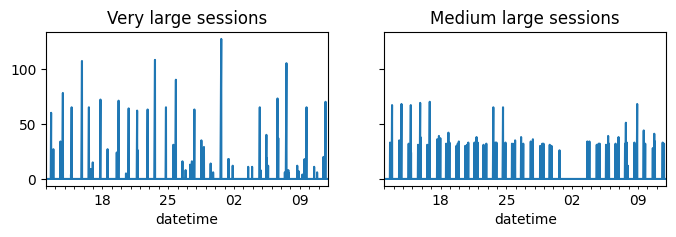

In [92]:
fig, axes = plt.subplots(1,2, figsize = (8,2), sharey = True)
df[df.Id == 8877689391 ].set_index('datetime')['streaks'].plot(title = 'Very large sessions',ax =axes[0])
axes[0].set_xticks([])

df[df.Id == 8053475328 ].set_index('datetime')['streaks'].plot(title= 'Medium large sessions',ax = axes[1])
axes[1].set_xticks([])


La idea es la siguiente. Entre las personas atléticas, contamos el número de veces que alcanzaron sesiones largas durante el mes. Entendemos una sesión larga como aquella que supera los 80 minutos. Una sesión media, las que superan los 50 minutos pero no pasan de los 80 minutos. Y sesiones cortas las inferiores a 50 minutos pero mayores a 30 minutos.

In [167]:
grouper_athl = df[df.Id.isin(athl.index)].groupby(['Id','Day_and_hour','Hour'])

large_sessions = (grouper_athl['streaks'].max() > 80).groupby(['Id']).sum()
large_sessions.name = 'large' 
mid_sessions = ((grouper_athl['streaks'].max() >=50 )& (grouper_athl['streaks'].max()<80)).groupby(['Id']).sum() 
mid_sessions.name= 'mid'
short_sessions = ((grouper_athl['streaks'].max() >=30 )& (grouper_athl['streaks'].max()<50)).groupby(['Id']).sum()
short_sessions.name = 'short'

sessions = pd.concat([short_sessions, mid_sessions, large_sessions], axis = 1)
print('Percentage of sessions of streaks per category')
(sessions.div(sessions.sum(axis=1), axis = 0)*100).applymap('{:,.0f}'.format)

Percentage of sessions of streaks per category


,short,mid,large
Id,,,
2022484408,89,11,0
6962181067,65,35,0
7086361926,62,38,0
8053475328,85,15,0
8378563200,31,69,0
8877689391,32,48,20


Note que los porcentajes de arriba pueden tener doble conteo, es decir puede que contemos una sesión de 90 minutos dos veces. La cadena que durá hasta 59 minutos y la siguiente hora continua hasta los 90 min aparece tanto en medio como en largo. Esto no nos importá por ahora. Con los porcentajes de la tabla anterior nos hacemos una idea de quienes hacen sesiones largas entre las personas atleticas y quienes no llegan a hacer tantas sesiones medias.

En particular hemos descubirto que **solo 1 persona prefiere las sesiones largas de ejercicio**. Y **otra persona prefiere las sesiones medio largas** de ejercicio entre las personas atléticas. Las otras **4 personas prefieren las sesiones cortas**.

Text(0.5, 1.0, 'Duration preference on workout sessions')

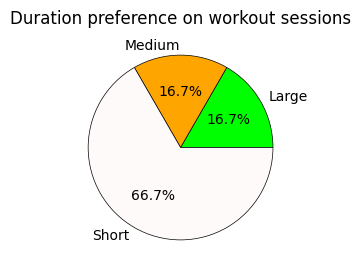

In [189]:
fig, ax = plt.subplots(figsize = (5,3))
large_sessionid = sessions.index[-1]
mid_sessionsid = sessions.index[-2]
short_sessionid = sessions.index[:4]

labels = ['Large', 'Medium', 'Short']
sizes = [1, 1, 4]
colors = ['lime', 'orange', 'snow']
ax.pie(sizes, labels= labels, autopct='%1.1f%%', colors = colors ,wedgeprops = {'edgecolor':'black' ,'linewidth': 0.5})
ax.set_title('Duration preference on workout sessions')

**Resumen A)**: Hemos podido identificar usuarios con todo tipo de preferencias: desde mayor actividad en las mañanas o en las tardes, hasta las duraciones preferidas para hacer ejercicio. En términos generales el 63% de los usarios son sedentarios y entre los que se ejercitan la preferencia es hacia sesiones en la tarde de no más de 50 minutos y preferiblemente los días lunes, martes y miércoles. Los domingos son los días más sedentarios para todos los usarios.

### B) Ejercicio y sueño

En esta sección exploraremos la relación de nuestros datos con el sueño en otro nivel. Recuerde que los datos fueron interpolados usando un algoritmo de _statistical matching_ y luego se les agrego ruido con una distribución normal. Aunque esto puede ser controvertido, el hecho de basarnos en otras medidas y añadir ruido nos permite respetar la distribución original de los datos y aún mantener cierto nivel de calidad sin añadir demasiado sesgo.

Intentamos responder: 
- ¿Qué relación hay entre la cantidad de sueño y el ejercicio?

Nota: Los datos de sueño están agregados por días. Los otros datos por minuto. Usar diferentes agregaciones puede llevar a resultados cuya interpretación puede ser totalmente distinta. Andamos por aguas pantanosas.

In [202]:
# First we create a key to merge 
df['Day'] = df['datetime'].dt.date
# We create a feature with name of dow to further aggregations later.
new_sleep['DayOfWeek'] = new_sleep['datetime'].dt.strftime('%A')

Hacemos algo de pre procesamiento.
En el código de abajo se ve la manera en la que decidimos agregar las diferentes variables. Por ejemplos:
- Tomamos la cadena de ejercicio más larga en un día dado.  
- Tomamos el promedio de intensidad. 
- Para todas las demás variables: la suma.

In [216]:

sleep_df = df.groupby(['Id', 'Day']).agg( Calories = ('Calories','sum'), \
                               Intensity_mean = ('Intensity','mean'),\
                               METs = ('METs','sum'),\
                               Steps = ('Steps', 'sum'),\
                               HertRate_sum = ('HeartRate','sum'),\
                               streaks_max = ('streaks', 'max')).reset_index()
sleep_df['Day'] = sleep_df['Day'].astype('datetime64[ns]')
sleep_df.head(2)

,Id,Day,Calories,Intensity_mean,METs,Steps,HertRate_sum,streaks_max
0,1624580081,2016-04-12,1432.145366,0.101389,17234,8163,50368.0,0
1,1624580081,2016-04-13,1411.868965,0.102778,16990,7007,54570.0,0


In [221]:
sleep = new_sleep.merge(sleep_df, how = 'inner',left_on =['Id', 'datetime'] , right_on = ['Id', 'Day'])
sleep.head(2)

,Id,datetime,TotalMinutesAsleep,TotalTimeInBed,DayOfWeek,Day,Calories,Intensity_mean,METs,Steps,HertRate_sum,streaks_max
0,1844505072,2016-04-12,604.0,961.0,Tuesday,2016-04-12,2030.843320,0.235417,21704,6697,87677.0,0
1,1844505072,2016-04-13,702.0,961.0,Wednesday,2016-04-13,1860.171632,0.172222,19880,4929,75830.0,0


In [ ]:
sleep

<AxesSubplot:xlabel='TotalMinutesAsleep', ylabel='Calories'>

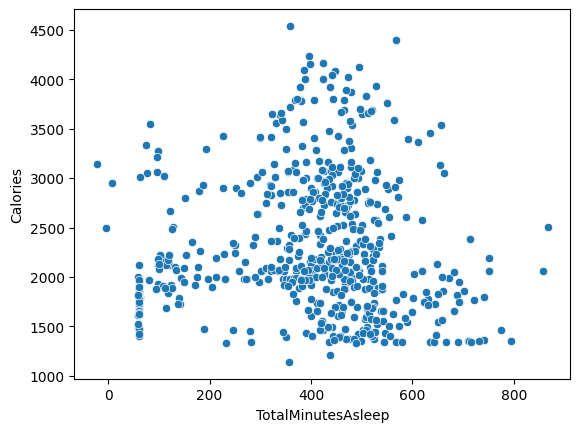

In [224]:
sns.scatterplot(data = sleep, x = 'TotalMinutesAsleep', y ='Calories' )

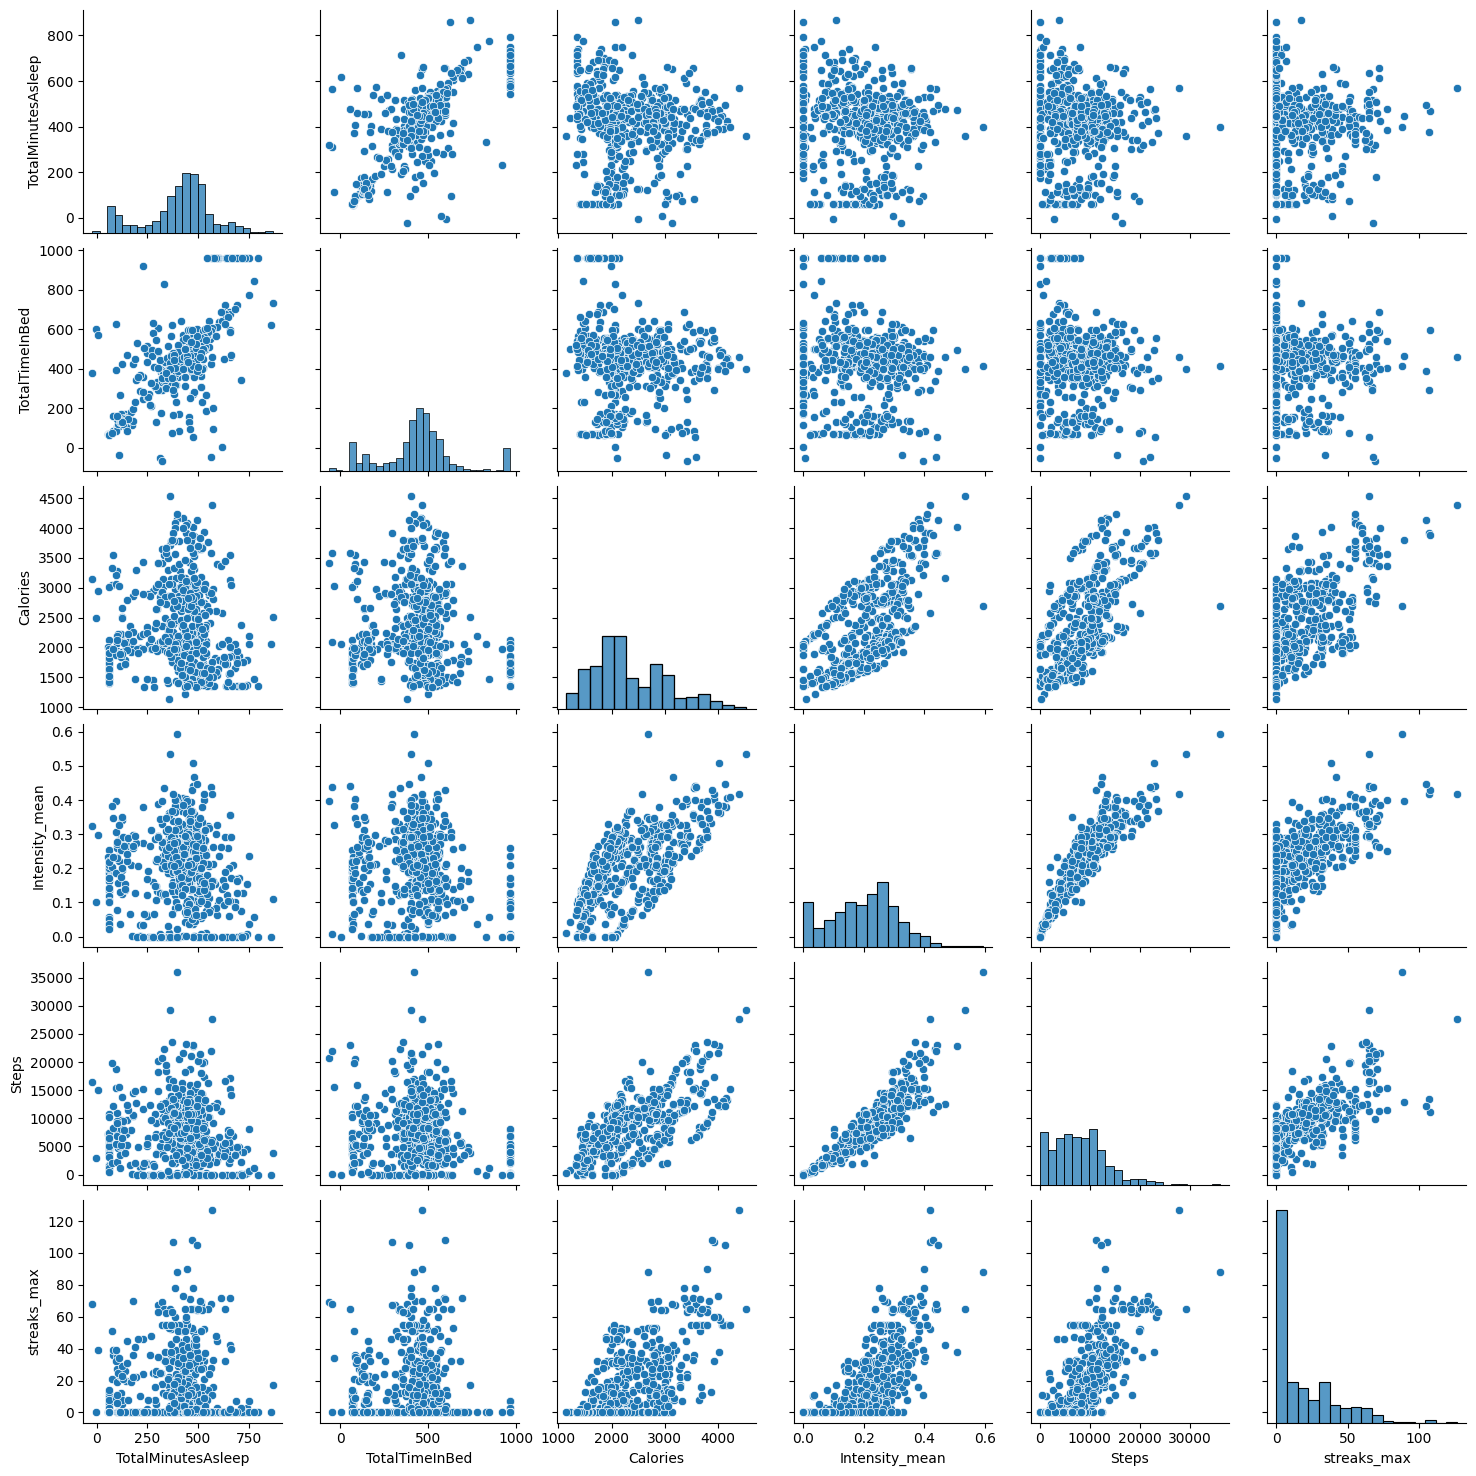

In [226]:
sns.pairplot(sleep[['TotalMinutesAsleep', 'TotalTimeInBed', 'Calories', 'Intensity_mean', 'Steps', 'streaks_max']])

## Apéndice
### A.1 carga de datasets y exploración de tablas

In [3]:
import os
import glob

path = r'C:\Users\diego\Desktop\Books_and_courses\Google_Data_Analysis_Prof_Certificate'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))# advisable to use os.path.join as this makes concatenation OS independent
# Leemos todos los dataframes
li = []
for f in all_files:
    df = pd.read_csv(f)
    li.append(df)
    
# Obtenemos los nombres de todos los archivos csv en este directorio
all_files = os.listdir('C:\\Users\\diego\\Desktop\\Books_and_courses\\Google_Data_Analysis_Prof_Certificate')    
csv_names = list(filter(lambda f: f.endswith('.csv'), all_files))
csv_names = [csv_names[i].replace('.csv', '') for i in range(len(csv_names))]

all_df = pd.Series(li, index = csv_names) # Series con todos los dataframes, indexados por sus nombres.

In [4]:
# Elimine la selección [:2] si desea ver la información de todos los dataframes.
for df in all_df[:2]:
    print( df.info() , '\n ------*-----\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        940 non-null    int64  
 1   ActivityDate              940 non-null    object 
 2   TotalSteps                940 non-null    int64  
 3   TotalDistance             940 non-null    float64
 4   TrackerDistance           940 non-null    float64
 5   LoggedActivitiesDistance  940 non-null    float64
 6   VeryActiveDistance        940 non-null    float64
 7   ModeratelyActiveDistance  940 non-null    float64
 8   LightActiveDistance       940 non-null    float64
 9   SedentaryActiveDistance   940 non-null    float64
 10  VeryActiveMinutes         940 non-null    int64  
 11  FairlyActiveMinutes       940 non-null    int64  
 12  LightlyActiveMinutes      940 non-null    int64  
 13  SedentaryMinutes          940 non-null    int64  
 14  Calories  

**Notas**
Se puede ver por la información anterior que los datos están separados como tablas relacionales. Algunas tablas sirven de apoyo a otras con información detallada de tiempo en distinta granularidad: diaria, por hora y por minutos. Aparentemente, los datos en _minutosXwide_ y _minutesXnarrow_ solo se diferencian en que una tabla contiene los datos en formato Wide y la otra en formato Long. Se puede decir que hay 4 categorías en las que los datos se encuentran más o menos completos:

* Intensidades
* Calorías
* Pasos
* Sueño

Otras carecterísticas con menor información son: Ritmo cardíaco, MET y peso. Particularmente peso tiene una considerbale cantidad de valores faltantes.

### A.2 Diferencias entre wide y narrow minutes data

In [5]:
# De algunos Id's hay mas registros y de otros menos. 
differences = (60*all_df['minuteCaloriesWide_merged']['Id'].value_counts()).sort_index() \
                - all_df['minuteCaloriesNarrow_merged']['Id'].value_counts().sort_index() #A grandes rasgos hay más datos en Narrow
differences

1503960366     120
1624580081    -420
1644430081   -1440
1844505072    -420
1927972279    -420
2022484408    -360
2026352035    -420
2320127002    -360
2347167796   -1440
2873212765    -660
3372868164   -1440
3977333714    1740
4020332650    -360
4057192912   -1440
4319703577   -1440
4388161847   -1200
4445114986    -360
4558609924   -1140
4702921684    -300
5553957443   -1440
5577150313   -1440
6117666160   -1440
6290855005   -1440
6775888955   -1440
6962181067    -240
7007744171   -1440
7086361926    -780
8053475328    -420
8253242879   -1440
8378563200    -360
8583815059   -1440
8792009665   -1440
8877689391    -360
Name: Id, dtype: int64

In [6]:
differences.value_counts() #At least there is a pattern between id's

-1440    14
-360      6
-420      5
 120      1
-660      1
 1740     1
-1200     1
-1140     1
-300      1
-240      1
-780      1
Name: Id, dtype: int64

In [7]:
# Por exploración sabemos que ambos conjuntos tienen los mismos id's. 
# La diferencia de registros se debe a la diferencia de rangos de fechas en cada dataset.

mins_wide = []
max_wide = []

mins_long = []
max_long = []
for id_number in all_df['minuteCaloriesNarrow_merged']['Id'].unique():
    bool_long = all_df['minuteCaloriesNarrow_merged']['Id'] == id_number 
    bool_wide =  all_df['minuteCaloriesWide_merged']['Id'] == id_number     

    long_data = all_df['minuteCaloriesNarrow_merged'].loc[bool_long, 'ActivityMinute']
    wide_data =  all_df['minuteCaloriesWide_merged'].loc[bool_wide, 'ActivityHour']

    long_data['dates'] =  pd.to_datetime(long_data, format = '%m/%d/%Y %I:%M:%S %p' )
    wide_data['dates'] =  pd.to_datetime(wide_data, format = '%m/%d/%Y %I:%M:%S %p' )
    
    print(id_number)
    print('WIDE', 'min:', min(wide_data['dates']) ,'MAX:', max(wide_data['dates']) )
    print('LONG:','min:' , min(long_data['dates']), 'MAX:' , max(long_data['dates']), '\n')
    mins_wide.append(min(wide_data['dates']))
    mins_long.append(min(long_data['dates']))
    max_wide.append(max(wide_data['dates']))
    max_long.append(max(long_data['dates']))
    



1503960366
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-12 22:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-11 20:59:00 

1624580081
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

1644430081
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-11 11:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-11 11:59:00 

1844505072
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 03:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 10:59:00 

1927972279
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

2022484408
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 14:59:00 

2026352035
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 15:59:00 

2320127002
WIDE min: 2016-04-13 00:00:00 MAX: 2016-05-13 08:00:00
LONG: min: 2016-04-12 00:00:00 MAX: 2016-05-12 14:59:00 

23471677

Con la gráfica de abajo resulta evidente que las diferencias en cantidad de registros en Calorías para Wide y narrow minutes se deben a que los datos pertenecen a rangos diferentes. Como regla general los datos de Calorías en Narrow (i.e. Long) empiezan un día antes (2016-04-12) que los datos en Wide (2016-04-13). Sin embargo, la mayor diferencia en registros se debe a los rangos máximos. En la mayoría de los casos Wide tiene una fecha mayor que long. En otros casos coinciden. No hay un rango de fechas largo que garantize que se contendrían ambos registros. De manera que no es compatible usar tanto Wide como Long. Lo recomendable es hacer una elección

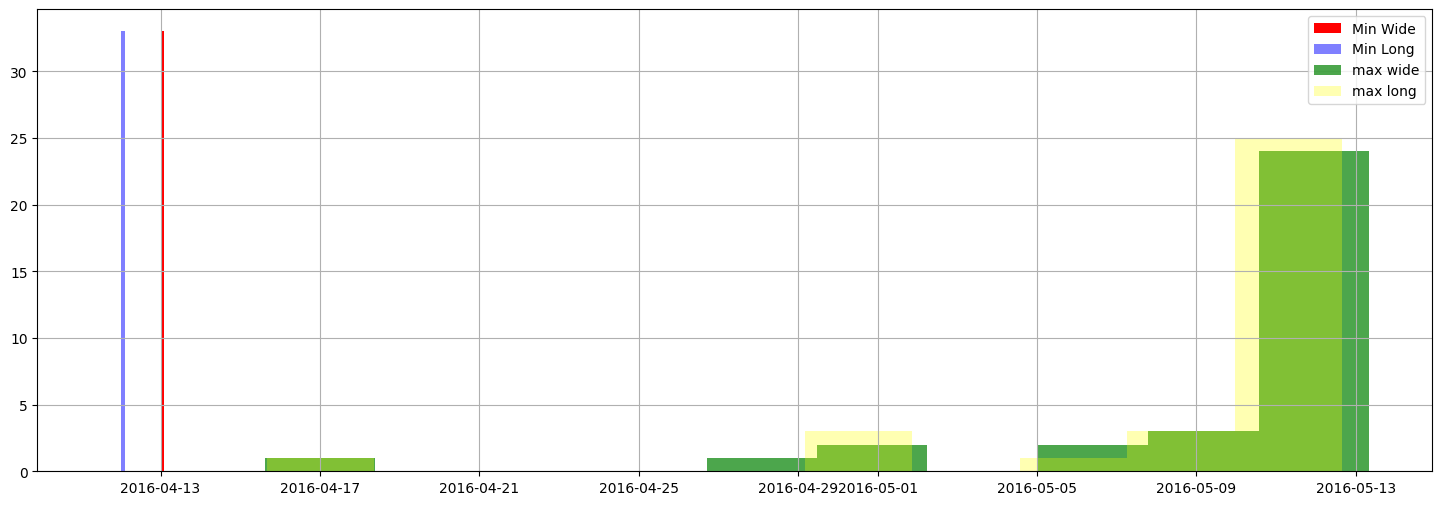

In [8]:
fig = plt.figure(figsize = (18,6))

pd.Series(mins_wide).hist(color = 'red', alpha = 1, label = 'Min Wide')
pd.Series(mins_long).hist(color = 'blue', alpha = 0.5 , label = 'Min Long')
pd.Series(max_wide).hist(color = 'green', alpha = 0.7, label = 'max wide')
pd.Series(max_long).hist(color = 'yellow', alpha = 0.3, label = 'max long')

plt.legend()

### A.3 Elección de minutes de acuerdo a consistencia con Hourly, Daily

Sabemos que los datos tienen una estructura jerárquica. Están agrupados por minutos -> Horas -> Días.

* ¿Los datos por horas representan los promedios cada 60 minutos? r:// No, son la suma de minutes Narrow
* ¿Acaso los datos por horas coinciden con los datos en long o en narrow format? r:// Narrow
* ¿Y los datos diarios sí coinciden con alguna agregación de los datos por horas? r://

Como paso previo convertimos todos los datos a formato datetime.

In [9]:
all_df['hourlyCalories_merged']['datetime'] = pd.to_datetime( all_df['hourlyCalories_merged'].pop('ActivityHour'), \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
all_df['hourlyCalories_merged']

,Id,Calories,datetime
0,1503960366,81,2016-04-12 00:00:00
1,1503960366,61,2016-04-12 01:00:00
2,1503960366,59,2016-04-12 02:00:00
3,1503960366,47,2016-04-12 03:00:00
4,1503960366,48,2016-04-12 04:00:00
...,...,...,...
22094,8877689391,126,2016-05-12 10:00:00
22095,8877689391,192,2016-05-12 11:00:00
22096,8877689391,321,2016-05-12 12:00:00
22097,8877689391,101,2016-05-12 13:00:00


Se usó **Narrow** minutes para agregar los datos. Long format es más adecuado para realizar calculos y además tiene más observaciones. Se identificó que los datos agrupados por horas representan la suma total de las calorías en minutos Narrow. 

In [10]:
all_df['minuteCaloriesNarrow_merged']['datetime'] = pd.to_datetime(all_df['minuteCaloriesNarrow_merged'].pop('ActivityMinute'), \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )


In [11]:
all_df['minuteCaloriesNarrow_merged']['Day_and_hour'] = all_df['minuteCaloriesNarrow_merged']['datetime'].dt.strftime('%Y-%m-%d %H')
all_df['minuteCaloriesNarrow_merged'].groupby(['Id','Day_and_hour'])['Calories'].sum()

Id          Day_and_hour 
1503960366  2016-04-12 00     81.324098
            2016-04-12 01     60.560498
            2016-04-12 02     58.830198
            2016-04-12 03     47.189999
            2016-04-12 04     47.504599
                                ...    
8877689391  2016-05-12 09     88.134207
            2016-05-12 10    126.079197
            2016-05-12 11    192.270776
            2016-05-12 12    320.774579
            2016-05-12 13    101.469507
Name: Calories, Length: 22093, dtype: float64

In [12]:
all_df['minuteCaloriesWide_merged']['ActivityHour'] = pd.to_datetime(all_df['minuteCaloriesWide_merged']['ActivityHour'], \
                                                         format = '%m/%d/%Y %I:%M:%S %p' )
values = all_df['minuteCaloriesWide_merged'].iloc[:, 2:].apply('sum', axis = 'columns')
values.index = all_df['minuteCaloriesWide_merged'][['Id','ActivityHour']]

In [13]:
values

(1503960366, 2016-04-13 00:00:00)     68.740098
(1503960366, 2016-04-13 01:00:00)     48.133799
(1503960366, 2016-04-13 02:00:00)     47.189999
(1503960366, 2016-04-13 03:00:00)     52.695498
(1503960366, 2016-04-13 04:00:00)     47.347299
                                        ...    
(8877689391, 2016-05-13 03:00:00)     73.020000
(8877689391, 2016-05-13 04:00:00)     73.020000
(8877689391, 2016-05-13 05:00:00)     73.020000
(8877689391, 2016-05-13 06:00:00)     99.307200
(8877689391, 2016-05-13 07:00:00)    164.173302
Length: 21645, dtype: float64

Veamos ahora los datos diarios

In [14]:
all_df['dailyCalories_merged']['datetime'] = pd.to_datetime(all_df['dailyCalories_merged'].pop('ActivityDay'))
all_df['dailyCalories_merged']

,Id,Calories,datetime
0,1503960366,1985,2016-04-12
1,1503960366,1797,2016-04-13
2,1503960366,1776,2016-04-14
3,1503960366,1745,2016-04-15
4,1503960366,1863,2016-04-16
...,...,...,...
935,8877689391,2847,2016-05-08
936,8877689391,3710,2016-05-09
937,8877689391,2832,2016-05-10
938,8877689391,3832,2016-05-11


Aunque los valores son cercanos, notamos algunas inconsistencias significativas. Posiblemente se deba a que la agregación en Hourly se hizo redondeando cifras.

In [15]:
all_df['hourlyCalories_merged']['date'] = all_df['hourlyCalories_merged']['datetime'].dt.date
all_df['hourlyCalories_merged'].groupby(['Id','date'])['Calories'].sum()

Id          date      
1503960366  2016-04-12    1988
            2016-04-13    1798
            2016-04-14    1776
            2016-04-15    1745
            2016-04-16    1866
                          ... 
8877689391  2016-05-08    2840
            2016-05-09    3695
            2016-05-10    2826
            2016-05-11    3827
            2016-05-12    1771
Name: Calories, Length: 934, dtype: int64

In [16]:
# Finalmente vemors dailyActivity que parece ser el dataset más grande
all_df['dailyActivity_merged'].head()

,Id,ActivityDate,TotalSteps,TotalDistance,TrackerDistance,LoggedActivitiesDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,4/12/2016,13162,8.50,8.50,0.0,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,4/13/2016,10735,6.97,6.97,0.0,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,4/14/2016,10460,6.74,6.74,0.0,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,4/15/2016,9762,6.28,6.28,0.0,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,4/16/2016,12669,8.16,8.16,0.0,2.71,0.41,5.04,0.0,36,10,221,773,1863


**Notas**: De acuerdo a lo anterior podemos suponer que los datos se corresponden con los encontrados en Narrow minutes. 
Las demás tablas se construyeron como agregaciones de Narrow minutes. Encontramos pequeñas inconsistencias en dichas agregaciones,
posiblemente debido a aproximaciones. En DailyActivity encontramos el merge de todos los datos.